In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from scipy import stats
import pyttsx3
import threading

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
draw_landmarks(frame, results)

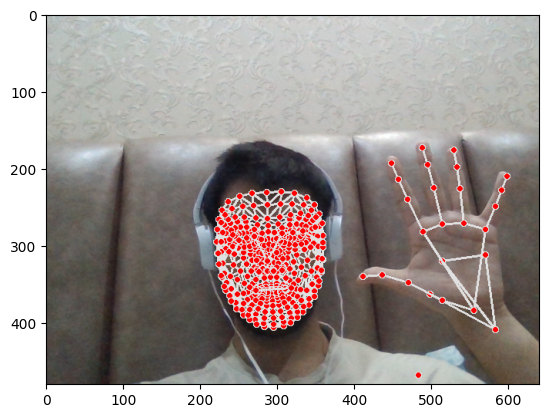

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [9]:
len(results.left_hand_landmarks.landmark)

21

In [10]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [11]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [12]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
result_test = extract_keypoints(results)

In [15]:
result_test

array([ 0.4487218 ,  0.66852415, -0.78202957, ...,  0.        ,
        0.        ,  0.        ])

In [16]:
np.save('0', result_test)

In [17]:
np.load('0.npy')

array([ 0.4487218 ,  0.66852415, -0.78202957, ...,  0.        ,
        0.        ,  0.        ])

In [18]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello','namaste','i love you', 'thanks', 'noaction', 'what', 'where', 'scissors', 'what time', 'salute', 'pen', 'phone', 'money', 'clothes', 'good', 'bad', 'all the best','choking', 'headache', 'salam'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0


In [19]:

for action in actions: 
    #dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(0,no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [369]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [20]:
cap.release()
cv2.destroyAllWindows()

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [22]:
label_map = {label:num for num, label in enumerate(actions)}

In [23]:
label_map

{'hello': 0,
 'namaste': 1,
 'i love you': 2,
 'thanks': 3,
 'noaction': 4,
 'what': 5,
 'where': 6,
 'scissors': 7,
 'what time': 8,
 'salute': 9,
 'pen': 10,
 'phone': 11,
 'money': 12,
 'clothes': 13,
 'good': 14,
 'bad': 15,
 'all the best': 16,
 'choking': 17,
 'headache': 18,
 'salam': 19}

In [25]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [26]:
np.array(sequences).shape

(600, 30, 1662)

In [27]:
res.shape

(1662,)

In [28]:
np.array(labels).shape

(600,)

In [29]:
X = np.array(sequences)

In [30]:
X.shape

(600, 30, 1662)

In [31]:
y = to_categorical(labels).astype(int)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [63]:
y_test.shape

(120, 20)

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

In [93]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [95]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [96]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [97]:
model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_data=(X_test, y_test), callbacks=[tb_callback])

Epoch 1/2000
15/15 [==============================] - 13s 597ms/step - loss: 2.9956 - categorical_accuracy: 0.0424 - val_loss: 2.9922 - val_categorical_accuracy: 0.0917
Epoch 2/2000
15/15 [==============================] - 6s 432ms/step - loss: 2.9762 - categorical_accuracy: 0.0829 - val_loss: 2.9264 - val_categorical_accuracy: 0.1083
Epoch 3/2000
15/15 [==============================] - 6s 416ms/step - loss: 2.9213 - categorical_accuracy: 0.1146 - val_loss: 2.8134 - val_categorical_accuracy: 0.1667
Epoch 4/2000
15/15 [==============================] - 6s 425ms/step - loss: 2.8142 - categorical_accuracy: 0.1186 - val_loss: 2.5430 - val_categorical_accuracy: 0.0917
Epoch 5/2000
15/15 [==============================] - 6s 394ms/step - loss: 2.7269 - categorical_accuracy: 0.1294 - val_loss: 2.4199 - val_categorical_accuracy: 0.2083
Epoch 6/2000
15/15 [==============================] - 6s 383ms/step - loss: 2.5100 - categorical_accuracy: 0.1760 - val_loss: 2.3261 - val_categorical_accuracy

15/15 [==============================] - 7s 445ms/step - loss: 0.4924 - categorical_accuracy: 0.8626 - val_loss: 0.2958 - val_categorical_accuracy: 0.9417
Epoch 98/2000
15/15 [==============================] - 6s 428ms/step - loss: 0.3079 - categorical_accuracy: 0.8986 - val_loss: 0.3603 - val_categorical_accuracy: 0.9250
Epoch 99/2000
15/15 [==============================] - 6s 413ms/step - loss: 0.2370 - categorical_accuracy: 0.9368 - val_loss: 0.2293 - val_categorical_accuracy: 0.9333
Epoch 100/2000
15/15 [==============================] - 6s 422ms/step - loss: 0.1737 - categorical_accuracy: 0.9445 - val_loss: 0.3287 - val_categorical_accuracy: 0.9250
Epoch 101/2000
15/15 [==============================] - 6s 418ms/step - loss: 0.1875 - categorical_accuracy: 0.9519 - val_loss: 0.2580 - val_categorical_accuracy: 0.9250
Epoch 102/2000
15/15 [==============================] - 6s 399ms/step - loss: 0.2047 - categorical_accuracy: 0.9380 - val_loss: 0.2804 - val_categorical_accuracy: 0.90

15/15 [==============================] - 6s 400ms/step - loss: 0.0166 - categorical_accuracy: 0.9967 - val_loss: 0.5700 - val_categorical_accuracy: 0.9083
Epoch 194/2000
15/15 [==============================] - 6s 409ms/step - loss: 0.0927 - categorical_accuracy: 0.9696 - val_loss: 0.3861 - val_categorical_accuracy: 0.9500
Epoch 195/2000
15/15 [==============================] - 6s 411ms/step - loss: 0.1042 - categorical_accuracy: 0.9663 - val_loss: 0.4523 - val_categorical_accuracy: 0.8500
Epoch 196/2000
15/15 [==============================] - 6s 404ms/step - loss: 0.1670 - categorical_accuracy: 0.9453 - val_loss: 0.3130 - val_categorical_accuracy: 0.9167
Epoch 197/2000
15/15 [==============================] - 6s 399ms/step - loss: 0.0438 - categorical_accuracy: 0.9922 - val_loss: 0.4023 - val_categorical_accuracy: 0.9583
Epoch 198/2000
15/15 [==============================] - 6s 419ms/step - loss: 0.0497 - categorical_accuracy: 0.9863 - val_loss: 0.3552 - val_categorical_accuracy: 0.

15/15 [==============================] - 6s 406ms/step - loss: 0.0285 - categorical_accuracy: 0.9951 - val_loss: 0.2148 - val_categorical_accuracy: 0.9417
Epoch 290/2000
15/15 [==============================] - 6s 415ms/step - loss: 0.0189 - categorical_accuracy: 0.9932 - val_loss: 0.3155 - val_categorical_accuracy: 0.9583
Epoch 291/2000
15/15 [==============================] - 6s 409ms/step - loss: 0.0071 - categorical_accuracy: 0.9970 - val_loss: 0.3622 - val_categorical_accuracy: 0.9500
Epoch 292/2000
15/15 [==============================] - 6s 407ms/step - loss: 0.0141 - categorical_accuracy: 0.9899 - val_loss: 0.4478 - val_categorical_accuracy: 0.9500
Epoch 293/2000
15/15 [==============================] - 6s 407ms/step - loss: 0.0360 - categorical_accuracy: 0.9934 - val_loss: 0.5029 - val_categorical_accuracy: 0.9250
Epoch 294/2000
15/15 [==============================] - 6s 404ms/step - loss: 0.1663 - categorical_accuracy: 0.9512 - val_loss: 0.2327 - val_categorical_accuracy: 0.

15/15 [==============================] - 6s 421ms/step - loss: 0.0258 - categorical_accuracy: 0.9911 - val_loss: 0.4845 - val_categorical_accuracy: 0.8917
Epoch 386/2000
15/15 [==============================] - 6s 419ms/step - loss: 0.0535 - categorical_accuracy: 0.9898 - val_loss: 0.3440 - val_categorical_accuracy: 0.9583
Epoch 387/2000
15/15 [==============================] - 6s 407ms/step - loss: 0.0329 - categorical_accuracy: 0.9917 - val_loss: 0.2312 - val_categorical_accuracy: 0.9667
Epoch 388/2000
15/15 [==============================] - 6s 408ms/step - loss: 0.0090 - categorical_accuracy: 0.9992 - val_loss: 0.3169 - val_categorical_accuracy: 0.9500
Epoch 389/2000
15/15 [==============================] - 6s 430ms/step - loss: 0.0038 - categorical_accuracy: 0.9996 - val_loss: 0.2813 - val_categorical_accuracy: 0.9667
Epoch 390/2000
15/15 [==============================] - 6s 422ms/step - loss: 0.0065 - categorical_accuracy: 0.9982 - val_loss: 0.4206 - val_categorical_accuracy: 0.

15/15 [==============================] - 7s 440ms/step - loss: 0.1424 - categorical_accuracy: 0.9762 - val_loss: 0.3553 - val_categorical_accuracy: 0.9250
Epoch 482/2000
15/15 [==============================] - 6s 412ms/step - loss: 0.1390 - categorical_accuracy: 0.9629 - val_loss: 0.1632 - val_categorical_accuracy: 0.9750
Epoch 483/2000
15/15 [==============================] - 6s 433ms/step - loss: 0.0760 - categorical_accuracy: 0.9857 - val_loss: 0.1763 - val_categorical_accuracy: 0.9500
Epoch 484/2000
15/15 [==============================] - 7s 445ms/step - loss: 0.0256 - categorical_accuracy: 0.9956 - val_loss: 0.3177 - val_categorical_accuracy: 0.9500
Epoch 485/2000
15/15 [==============================] - 6s 423ms/step - loss: 0.0194 - categorical_accuracy: 0.9939 - val_loss: 0.4506 - val_categorical_accuracy: 0.9500
Epoch 486/2000
15/15 [==============================] - 7s 443ms/step - loss: 0.0307 - categorical_accuracy: 0.9954 - val_loss: 0.3264 - val_categorical_accuracy: 0.

15/15 [==============================] - 6s 431ms/step - loss: 0.0202 - categorical_accuracy: 0.9931 - val_loss: 0.1996 - val_categorical_accuracy: 0.9583
Epoch 578/2000
15/15 [==============================] - 6s 426ms/step - loss: 0.0131 - categorical_accuracy: 0.9945 - val_loss: 0.2987 - val_categorical_accuracy: 0.9500
Epoch 579/2000
15/15 [==============================] - 6s 427ms/step - loss: 0.0119 - categorical_accuracy: 0.9934 - val_loss: 0.1652 - val_categorical_accuracy: 0.9667
Epoch 580/2000
15/15 [==============================] - 6s 424ms/step - loss: 0.0330 - categorical_accuracy: 0.9938 - val_loss: 0.6166 - val_categorical_accuracy: 0.9333
Epoch 581/2000
15/15 [==============================] - 7s 445ms/step - loss: 0.0051 - categorical_accuracy: 1.0000 - val_loss: 0.3229 - val_categorical_accuracy: 0.9667
Epoch 582/2000
15/15 [==============================] - 6s 426ms/step - loss: 0.0053 - categorical_accuracy: 1.0000 - val_loss: 0.4653 - val_categorical_accuracy: 0.

15/15 [==============================] - 6s 377ms/step - loss: 0.0150 - categorical_accuracy: 0.9970 - val_loss: 0.4995 - val_categorical_accuracy: 0.9583
Epoch 674/2000
15/15 [==============================] - 6s 384ms/step - loss: 0.0046 - categorical_accuracy: 1.0000 - val_loss: 0.5093 - val_categorical_accuracy: 0.9667
Epoch 675/2000
15/15 [==============================] - 6s 400ms/step - loss: 0.0056 - categorical_accuracy: 1.0000 - val_loss: 0.4781 - val_categorical_accuracy: 0.9667
Epoch 676/2000
15/15 [==============================] - 6s 393ms/step - loss: 0.0037 - categorical_accuracy: 0.9994 - val_loss: 0.4229 - val_categorical_accuracy: 0.9750
Epoch 677/2000
15/15 [==============================] - 6s 394ms/step - loss: 7.0363e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4238 - val_categorical_accuracy: 0.9750
Epoch 678/2000
15/15 [==============================] - 6s 384ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.4625 - val_categorical_accuracy

15/15 [==============================] - 4s 281ms/step - loss: 0.0182 - categorical_accuracy: 0.9933 - val_loss: 0.5479 - val_categorical_accuracy: 0.9667
Epoch 770/2000
15/15 [==============================] - 4s 281ms/step - loss: 0.0017 - categorical_accuracy: 1.0000 - val_loss: 0.5188 - val_categorical_accuracy: 0.9667
Epoch 771/2000
15/15 [==============================] - 4s 283ms/step - loss: 0.0182 - categorical_accuracy: 0.9974 - val_loss: 0.4703 - val_categorical_accuracy: 0.9583
Epoch 772/2000
15/15 [==============================] - 4s 277ms/step - loss: 0.0150 - categorical_accuracy: 0.9985 - val_loss: 0.3534 - val_categorical_accuracy: 0.9667
Epoch 773/2000
15/15 [==============================] - 4s 276ms/step - loss: 0.0290 - categorical_accuracy: 0.9953 - val_loss: 0.3087 - val_categorical_accuracy: 0.9667
Epoch 774/2000
15/15 [==============================] - 4s 285ms/step - loss: 0.0145 - categorical_accuracy: 0.9959 - val_loss: 0.4166 - val_categorical_accuracy: 0.

15/15 [==============================] - 4s 274ms/step - loss: 0.1567 - categorical_accuracy: 0.9546 - val_loss: 0.1020 - val_categorical_accuracy: 0.9750
Epoch 818/2000
15/15 [==============================] - 4s 270ms/step - loss: 0.0463 - categorical_accuracy: 0.9913 - val_loss: 0.1018 - val_categorical_accuracy: 0.9750
Epoch 819/2000
15/15 [==============================] - 4s 273ms/step - loss: 0.0220 - categorical_accuracy: 0.9941 - val_loss: 0.2455 - val_categorical_accuracy: 0.9750
Epoch 820/2000
15/15 [==============================] - 4s 273ms/step - loss: 0.0143 - categorical_accuracy: 0.9947 - val_loss: 0.1700 - val_categorical_accuracy: 0.9833
Epoch 821/2000
15/15 [==============================] - 4s 277ms/step - loss: 0.0212 - categorical_accuracy: 0.9962 - val_loss: 0.3435 - val_categorical_accuracy: 0.9500
Epoch 822/2000
15/15 [==============================] - 4s 283ms/step - loss: 0.3259 - categorical_accuracy: 0.9533 - val_loss: 0.3705 - val_categorical_accuracy: 0.

15/15 [==============================] - 4s 277ms/step - loss: 0.0033 - categorical_accuracy: 0.9981 - val_loss: 0.3133 - val_categorical_accuracy: 0.9583
Epoch 914/2000
15/15 [==============================] - 4s 277ms/step - loss: 0.0202 - categorical_accuracy: 0.9908 - val_loss: 0.2225 - val_categorical_accuracy: 0.9750
Epoch 915/2000
15/15 [==============================] - 4s 281ms/step - loss: 0.0018 - categorical_accuracy: 1.0000 - val_loss: 0.2296 - val_categorical_accuracy: 0.9750
Epoch 916/2000
15/15 [==============================] - 4s 270ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.2399 - val_categorical_accuracy: 0.9750
Epoch 917/2000
15/15 [==============================] - 5s 313ms/step - loss: 5.4935e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2534 - val_categorical_accuracy: 0.9750
Epoch 918/2000
15/15 [==============================] - 4s 268ms/step - loss: 5.6255e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2668 - val_categorical_accu

15/15 [==============================] - 4s 262ms/step - loss: 0.0095 - categorical_accuracy: 0.9981 - val_loss: 0.5862 - val_categorical_accuracy: 0.9667
Epoch 962/2000
15/15 [==============================] - 4s 259ms/step - loss: 0.0094 - categorical_accuracy: 0.9985 - val_loss: 0.5074 - val_categorical_accuracy: 0.9667
Epoch 963/2000
15/15 [==============================] - 4s 261ms/step - loss: 0.0028 - categorical_accuracy: 0.9987 - val_loss: 0.6029 - val_categorical_accuracy: 0.9250
Epoch 964/2000
15/15 [==============================] - 4s 265ms/step - loss: 0.0213 - categorical_accuracy: 0.9928 - val_loss: 0.6076 - val_categorical_accuracy: 0.9500
Epoch 965/2000
15/15 [==============================] - 4s 261ms/step - loss: 0.0211 - categorical_accuracy: 0.9872 - val_loss: 0.3215 - val_categorical_accuracy: 0.9750
Epoch 966/2000
15/15 [==============================] - 4s 265ms/step - loss: 0.0128 - categorical_accuracy: 0.9944 - val_loss: 0.4213 - val_categorical_accuracy: 0.

Epoch 1009/2000
15/15 [==============================] - 4s 263ms/step - loss: 4.1192e-04 - categorical_accuracy: 1.0000 - val_loss: 0.6922 - val_categorical_accuracy: 0.9583
Epoch 1010/2000
15/15 [==============================] - 4s 265ms/step - loss: 9.1631e-04 - categorical_accuracy: 1.0000 - val_loss: 0.6339 - val_categorical_accuracy: 0.9583
Epoch 1011/2000
15/15 [==============================] - 4s 262ms/step - loss: 0.0027 - categorical_accuracy: 1.0000 - val_loss: 0.6419 - val_categorical_accuracy: 0.9583
Epoch 1012/2000
15/15 [==============================] - 4s 262ms/step - loss: 0.0020 - categorical_accuracy: 1.0000 - val_loss: 0.7033 - val_categorical_accuracy: 0.9583
Epoch 1013/2000
15/15 [==============================] - 4s 262ms/step - loss: 2.0967e-04 - categorical_accuracy: 1.0000 - val_loss: 0.6791 - val_categorical_accuracy: 0.9583
Epoch 1014/2000
15/15 [==============================] - 4s 271ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 0.67

Epoch 1104/2000
15/15 [==============================] - 4s 253ms/step - loss: 9.1736e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3746 - val_categorical_accuracy: 0.9667
Epoch 1105/2000
15/15 [==============================] - 4s 256ms/step - loss: 6.2327e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3443 - val_categorical_accuracy: 0.9667
Epoch 1106/2000
15/15 [==============================] - 4s 257ms/step - loss: 0.0018 - categorical_accuracy: 1.0000 - val_loss: 0.3214 - val_categorical_accuracy: 0.9750
Epoch 1107/2000
15/15 [==============================] - 4s 262ms/step - loss: 0.0033 - categorical_accuracy: 1.0000 - val_loss: 0.5141 - val_categorical_accuracy: 0.9500
Epoch 1108/2000
15/15 [==============================] - 4s 258ms/step - loss: 0.0038 - categorical_accuracy: 0.9982 - val_loss: 0.6227 - val_categorical_accuracy: 0.9417
Epoch 1109/2000
15/15 [==============================] - 4s 271ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 0.5603 -

Epoch 1152/2000
15/15 [==============================] - 28s 2s/step - loss: 0.0081 - categorical_accuracy: 0.9993 - val_loss: 0.2342 - val_categorical_accuracy: 0.9583
Epoch 1153/2000
15/15 [==============================] - 9s 537ms/step - loss: 0.0098 - categorical_accuracy: 0.9970 - val_loss: 0.2994 - val_categorical_accuracy: 0.9500
Epoch 1154/2000
15/15 [==============================] - 3s 215ms/step - loss: 0.0043 - categorical_accuracy: 1.0000 - val_loss: 0.2702 - val_categorical_accuracy: 0.9583
Epoch 1155/2000
15/15 [==============================] - 3s 216ms/step - loss: 0.0044 - categorical_accuracy: 1.0000 - val_loss: 0.2473 - val_categorical_accuracy: 0.9667
Epoch 1156/2000
15/15 [==============================] - 3s 220ms/step - loss: 0.0103 - categorical_accuracy: 0.9993 - val_loss: 0.2244 - val_categorical_accuracy: 0.9667
Epoch 1157/2000
15/15 [==============================] - 3s 216ms/step - loss: 0.0084 - categorical_accuracy: 0.9950 - val_loss: 0.1864 - val_categ

Epoch 1247/2000
15/15 [==============================] - 4s 246ms/step - loss: 0.0049 - categorical_accuracy: 0.9987 - val_loss: 0.2917 - val_categorical_accuracy: 0.9750
Epoch 1248/2000
15/15 [==============================] - 4s 244ms/step - loss: 6.6019e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2978 - val_categorical_accuracy: 0.9750
Epoch 1249/2000
15/15 [==============================] - 4s 246ms/step - loss: 5.3038e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2999 - val_categorical_accuracy: 0.9750
Epoch 1250/2000
15/15 [==============================] - 4s 248ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.3026 - val_categorical_accuracy: 0.9750
Epoch 1251/2000
15/15 [==============================] - 4s 249ms/step - loss: 1.9612e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3039 - val_categorical_accuracy: 0.9750
Epoch 1252/2000
15/15 [==============================] - 4s 249ms/step - loss: 0.0035 - categorical_accuracy: 0.9978 - val_loss: 0.30

15/15 [==============================] - 4s 248ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 0.2952 - val_categorical_accuracy: 0.9667
Epoch 1342/2000
15/15 [==============================] - 4s 247ms/step - loss: 2.1952e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3318 - val_categorical_accuracy: 0.9667
Epoch 1343/2000
15/15 [==============================] - 4s 245ms/step - loss: 2.1978e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3454 - val_categorical_accuracy: 0.9667
Epoch 1344/2000
15/15 [==============================] - 4s 249ms/step - loss: 1.1285e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3505 - val_categorical_accuracy: 0.9667
Epoch 1345/2000
15/15 [==============================] - 4s 253ms/step - loss: 2.1438e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3561 - val_categorical_accuracy: 0.9667
Epoch 1346/2000
15/15 [==============================] - 4s 246ms/step - loss: 1.6872e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3584 - val

Epoch 1389/2000
15/15 [==============================] - 4s 243ms/step - loss: 0.0019 - categorical_accuracy: 1.0000 - val_loss: 0.5469 - val_categorical_accuracy: 0.9500
Epoch 1390/2000
15/15 [==============================] - 4s 241ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.4874 - val_categorical_accuracy: 0.9500
Epoch 1391/2000
15/15 [==============================] - 4s 246ms/step - loss: 0.0025 - categorical_accuracy: 1.0000 - val_loss: 0.4535 - val_categorical_accuracy: 0.9500
Epoch 1392/2000
15/15 [==============================] - 4s 271ms/step - loss: 0.0058 - categorical_accuracy: 1.0000 - val_loss: 0.4606 - val_categorical_accuracy: 0.9583
Epoch 1393/2000
15/15 [==============================] - 4s 253ms/step - loss: 0.0028 - categorical_accuracy: 1.0000 - val_loss: 0.5183 - val_categorical_accuracy: 0.9333
Epoch 1394/2000
15/15 [==============================] - 4s 250ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.5105 - val_cat

Epoch 1437/2000
15/15 [==============================] - 5s 309ms/step - loss: 0.0130 - categorical_accuracy: 1.0000 - val_loss: 0.3216 - val_categorical_accuracy: 0.9333
Epoch 1438/2000
15/15 [==============================] - 4s 279ms/step - loss: 0.0053 - categorical_accuracy: 1.0000 - val_loss: 0.2775 - val_categorical_accuracy: 0.9500
Epoch 1439/2000
15/15 [==============================] - 4s 284ms/step - loss: 0.0021 - categorical_accuracy: 1.0000 - val_loss: 0.2620 - val_categorical_accuracy: 0.9583
Epoch 1440/2000
15/15 [==============================] - 4s 274ms/step - loss: 0.0026 - categorical_accuracy: 1.0000 - val_loss: 0.2702 - val_categorical_accuracy: 0.9583
Epoch 1441/2000
15/15 [==============================] - 4s 271ms/step - loss: 4.7105e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2830 - val_categorical_accuracy: 0.9583
Epoch 1442/2000
15/15 [==============================] - 4s 275ms/step - loss: 0.0095 - categorical_accuracy: 0.9963 - val_loss: 0.2228 - val

15/15 [==============================] - 4s 245ms/step - loss: 0.0242 - categorical_accuracy: 0.9934 - val_loss: 0.2209 - val_categorical_accuracy: 0.9583
Epoch 1532/2000
15/15 [==============================] - 4s 248ms/step - loss: 0.0038 - categorical_accuracy: 1.0000 - val_loss: 0.2567 - val_categorical_accuracy: 0.9500
Epoch 1533/2000
15/15 [==============================] - 4s 245ms/step - loss: 0.0226 - categorical_accuracy: 0.9927 - val_loss: 0.1610 - val_categorical_accuracy: 0.9583
Epoch 1534/2000
15/15 [==============================] - 4s 246ms/step - loss: 0.0395 - categorical_accuracy: 0.9855 - val_loss: 0.2179 - val_categorical_accuracy: 0.9583
Epoch 1535/2000
15/15 [==============================] - 4s 245ms/step - loss: 0.0033 - categorical_accuracy: 1.0000 - val_loss: 0.1724 - val_categorical_accuracy: 0.9750
Epoch 1536/2000
15/15 [==============================] - 4s 245ms/step - loss: 0.0127 - categorical_accuracy: 0.9950 - val_loss: 0.2914 - val_categorical_accurac

Epoch 1579/2000
15/15 [==============================] - 4s 249ms/step - loss: 5.3399e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4366 - val_categorical_accuracy: 0.9583
Epoch 1580/2000
15/15 [==============================] - 4s 264ms/step - loss: 9.8311e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4503 - val_categorical_accuracy: 0.9583
Epoch 1581/2000
15/15 [==============================] - 4s 246ms/step - loss: 3.8400e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4624 - val_categorical_accuracy: 0.9583
Epoch 1582/2000
15/15 [==============================] - 4s 243ms/step - loss: 5.2438e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4794 - val_categorical_accuracy: 0.9583
Epoch 1583/2000
15/15 [==============================] - 4s 244ms/step - loss: 7.9812e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4636 - val_categorical_accuracy: 0.9583
Epoch 1584/2000
15/15 [==============================] - 4s 245ms/step - loss: 3.5236e-04 - categorical_accuracy: 1.0000 - va

15/15 [==============================] - 4s 264ms/step - loss: 9.3029e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8861 - val_categorical_accuracy: 0.9667
Epoch 1674/2000
15/15 [==============================] - 4s 262ms/step - loss: 0.0074 - categorical_accuracy: 0.9963 - val_loss: 1.0629 - val_categorical_accuracy: 0.9667
Epoch 1675/2000
15/15 [==============================] - 4s 246ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 1.0106 - val_categorical_accuracy: 0.9667
Epoch 1676/2000
15/15 [==============================] - 4s 246ms/step - loss: 8.7006e-04 - categorical_accuracy: 1.0000 - val_loss: 0.9302 - val_categorical_accuracy: 0.9583
Epoch 1677/2000
15/15 [==============================] - 4s 244ms/step - loss: 5.0822e-04 - categorical_accuracy: 1.0000 - val_loss: 0.9188 - val_categorical_accuracy: 0.9583
Epoch 1678/2000
15/15 [==============================] - 4s 242ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 0.9026 - val_categor

15/15 [==============================] - 4s 241ms/step - loss: 5.0560e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2729 - val_categorical_accuracy: 0.9667
Epoch 1768/2000
15/15 [==============================] - 4s 243ms/step - loss: 2.8668e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2868 - val_categorical_accuracy: 0.9667
Epoch 1769/2000
15/15 [==============================] - 4s 246ms/step - loss: 2.6913e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2899 - val_categorical_accuracy: 0.9667
Epoch 1770/2000
15/15 [==============================] - 4s 245ms/step - loss: 2.5647e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2912 - val_categorical_accuracy: 0.9667
Epoch 1771/2000
15/15 [==============================] - 4s 246ms/step - loss: 0.0055 - categorical_accuracy: 0.9987 - val_loss: 0.2846 - val_categorical_accuracy: 0.9667
Epoch 1772/2000
15/15 [==============================] - 4s 242ms/step - loss: 2.0973e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2856 - val

15/15 [==============================] - 5s 306ms/step - loss: 0.0085 - categorical_accuracy: 0.9934 - val_loss: 0.2999 - val_categorical_accuracy: 0.9583
Epoch 1862/2000
15/15 [==============================] - 5s 316ms/step - loss: 0.0039 - categorical_accuracy: 1.0000 - val_loss: 0.4209 - val_categorical_accuracy: 0.9667
Epoch 1863/2000
15/15 [==============================] - 5s 306ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.4555 - val_categorical_accuracy: 0.9667
Epoch 1864/2000
15/15 [==============================] - 5s 312ms/step - loss: 3.5807e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4694 - val_categorical_accuracy: 0.9667
Epoch 1865/2000
15/15 [==============================] - 5s 335ms/step - loss: 6.8285e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4811 - val_categorical_accuracy: 0.9667
Epoch 1866/2000
15/15 [==============================] - 5s 306ms/step - loss: 5.6306e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4993 - val_categor

15/15 [==============================] - 4s 295ms/step - loss: 0.1742 - categorical_accuracy: 0.9771 - val_loss: 0.5020 - val_categorical_accuracy: 0.9583
Epoch 1956/2000
15/15 [==============================] - 4s 252ms/step - loss: 0.0173 - categorical_accuracy: 0.9977 - val_loss: 0.6114 - val_categorical_accuracy: 0.9583
Epoch 1957/2000
15/15 [==============================] - 4s 242ms/step - loss: 0.0611 - categorical_accuracy: 0.9932 - val_loss: 0.1641 - val_categorical_accuracy: 0.9667
Epoch 1958/2000
15/15 [==============================] - 4s 239ms/step - loss: 0.0830 - categorical_accuracy: 0.9903 - val_loss: 0.2453 - val_categorical_accuracy: 0.9333
Epoch 1959/2000
15/15 [==============================] - 4s 297ms/step - loss: 0.0114 - categorical_accuracy: 1.0000 - val_loss: 0.2169 - val_categorical_accuracy: 0.9583
Epoch 1960/2000
15/15 [==============================] - 4s 253ms/step - loss: 0.0031 - categorical_accuracy: 1.0000 - val_loss: 0.2702 - val_categorical_accurac

In [98]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 30, 128)           916992    
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 30, 256)           394240    
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)               

In [99]:
res = model.predict(X_test)

In [100]:
res.shape

(120, 20)

In [101]:
actions[np.argmax(res[1])]

'where'

In [102]:
actions[np.argmax(y_test[1])]

'where'

In [103]:
model.save('action.h5')

In [104]:
#from tensorflow.keras import Model
model.load_weights('action.h5')

In [105]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [106]:
yhat = model.predict(X_test)

In [107]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5
           3       1.00      0.86      0.92         7
           4       1.00      1.00      1.00         9
           5       0.80      1.00      0.89         4
           6       1.00      0.86      0.92         7
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         6
           9       0.86      0.86      0.86         7
          10       1.00      1.00      1.00         7
          11       1.00      0.86      0.92         7
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         9
          15       0.80      1.00      0.89         4
          16       1.00      1.00      1.00         7
          17       1.00    

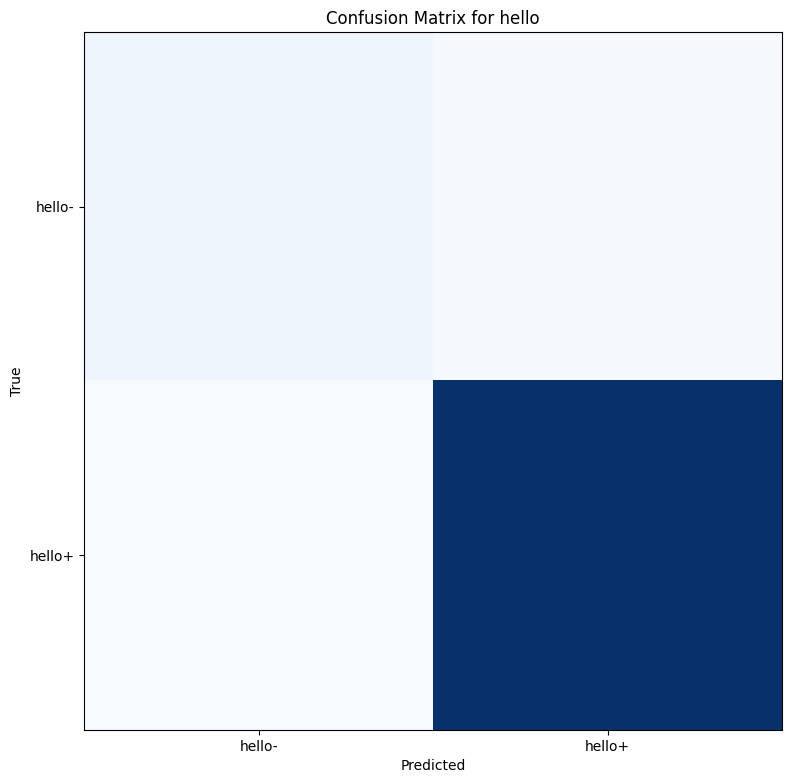

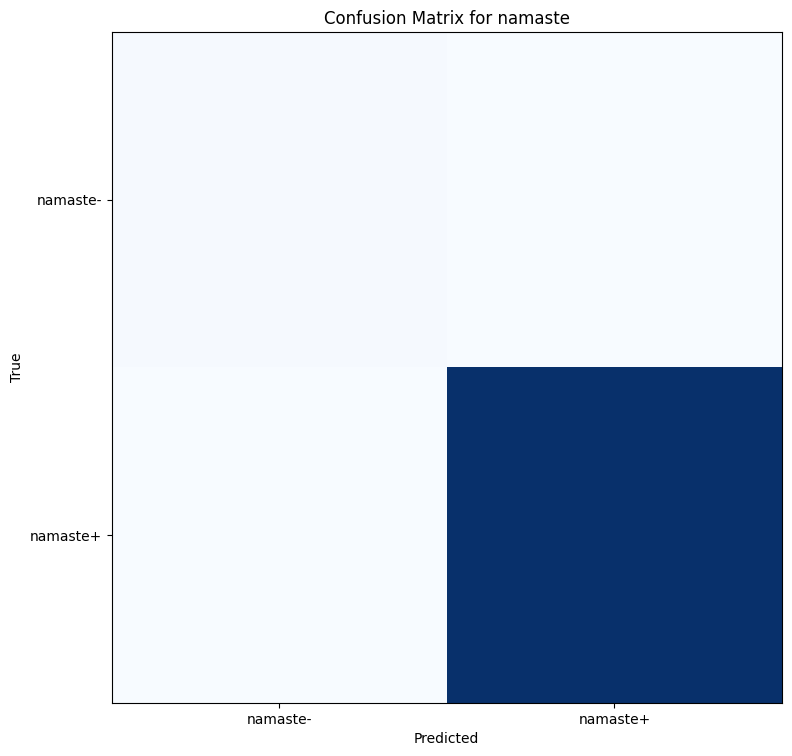

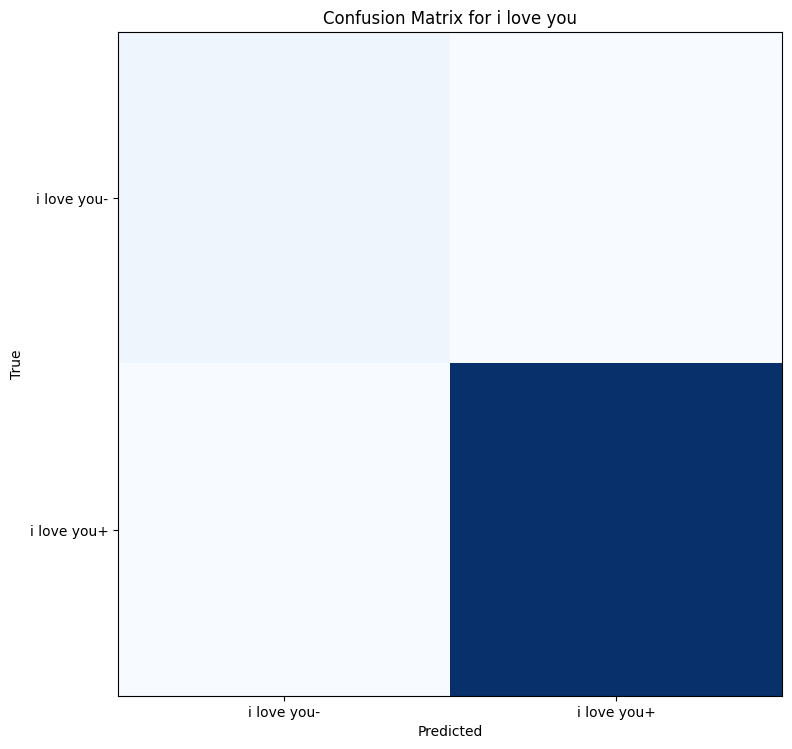

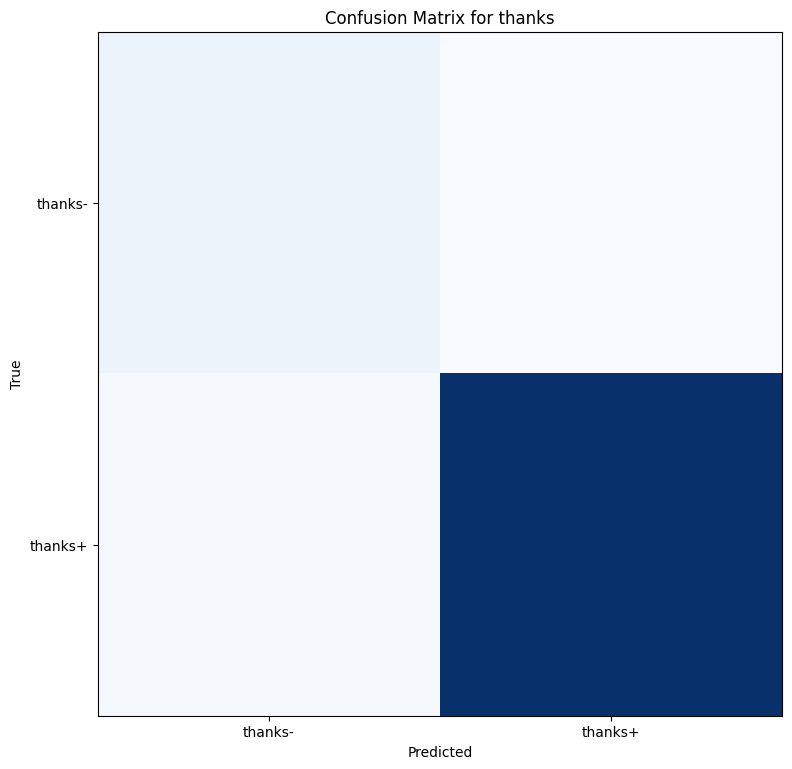

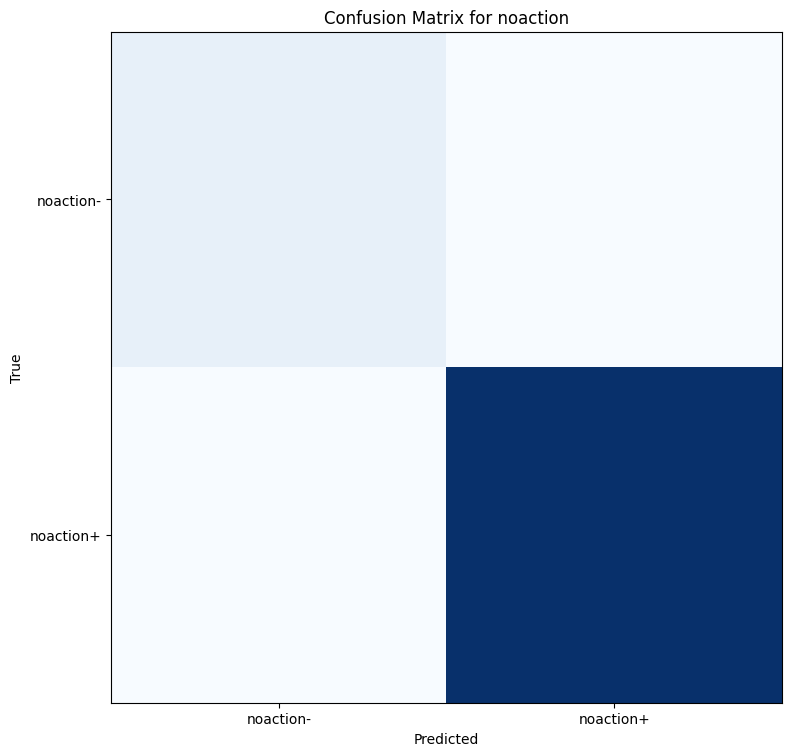

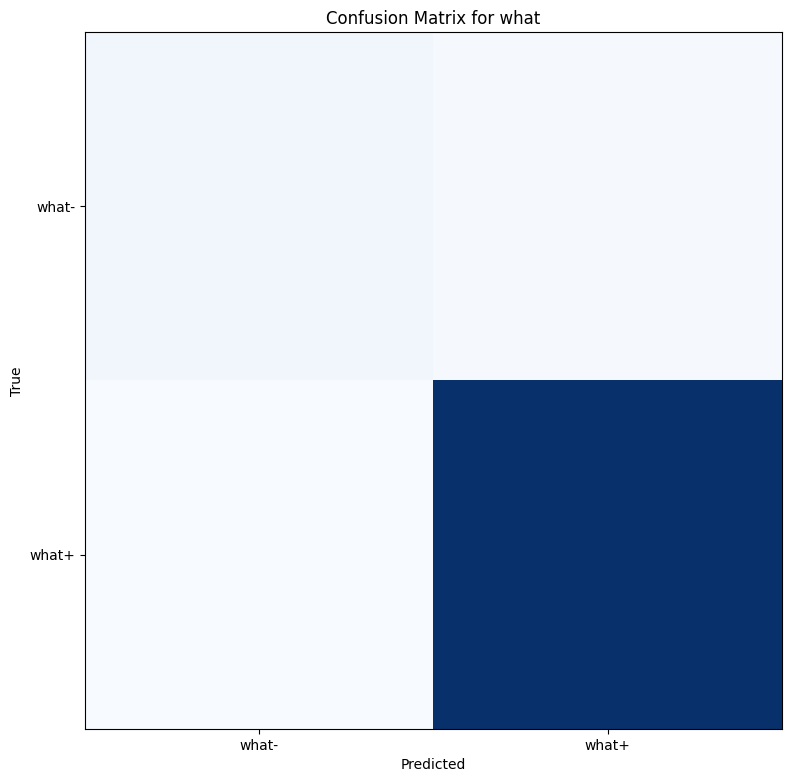

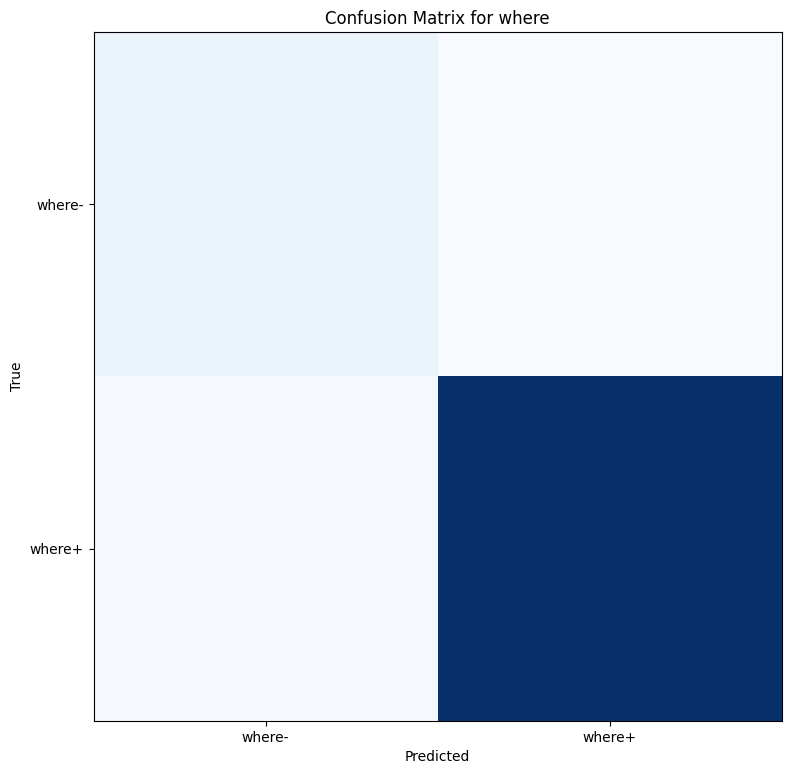

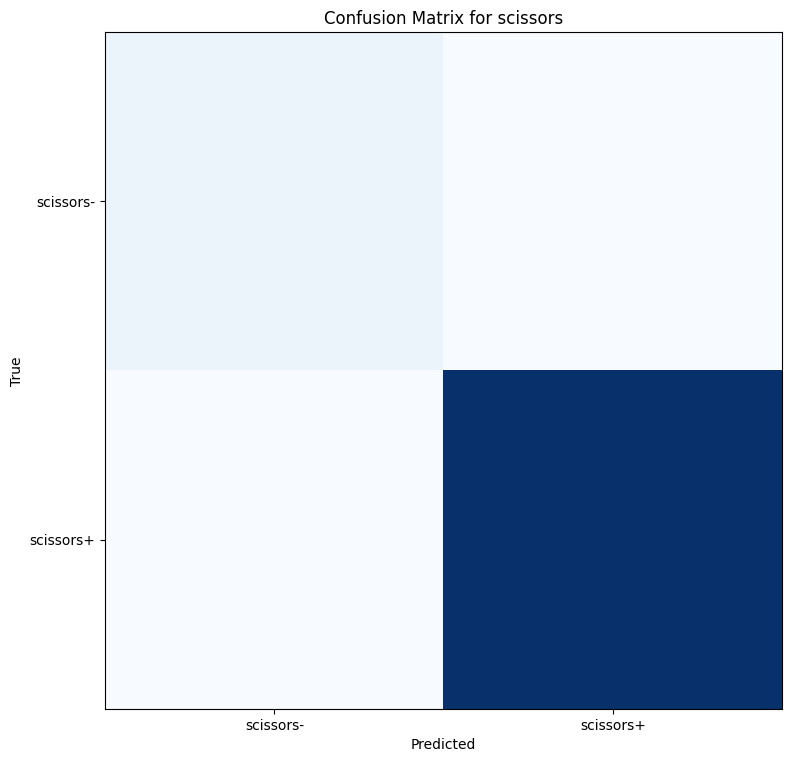

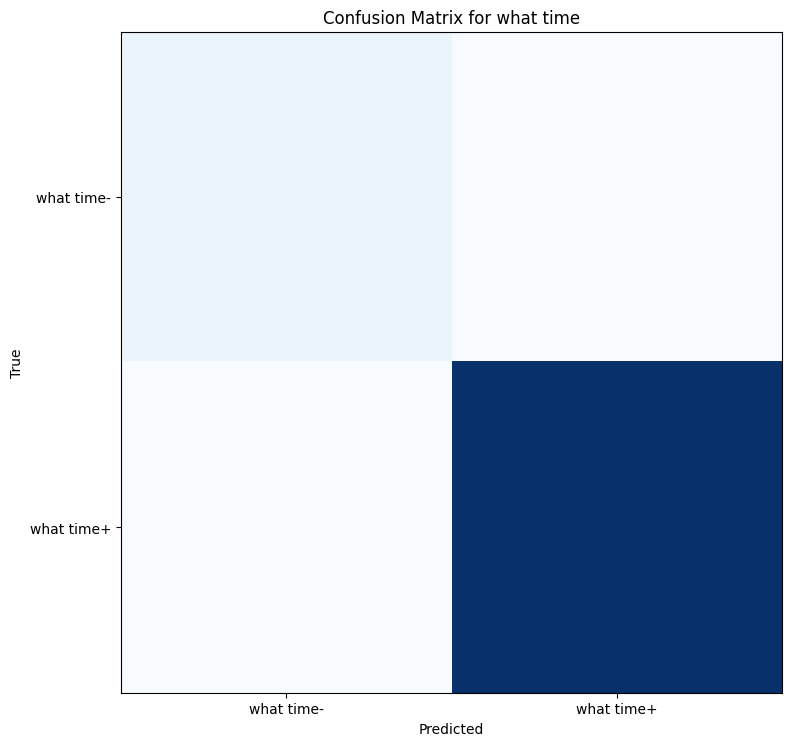

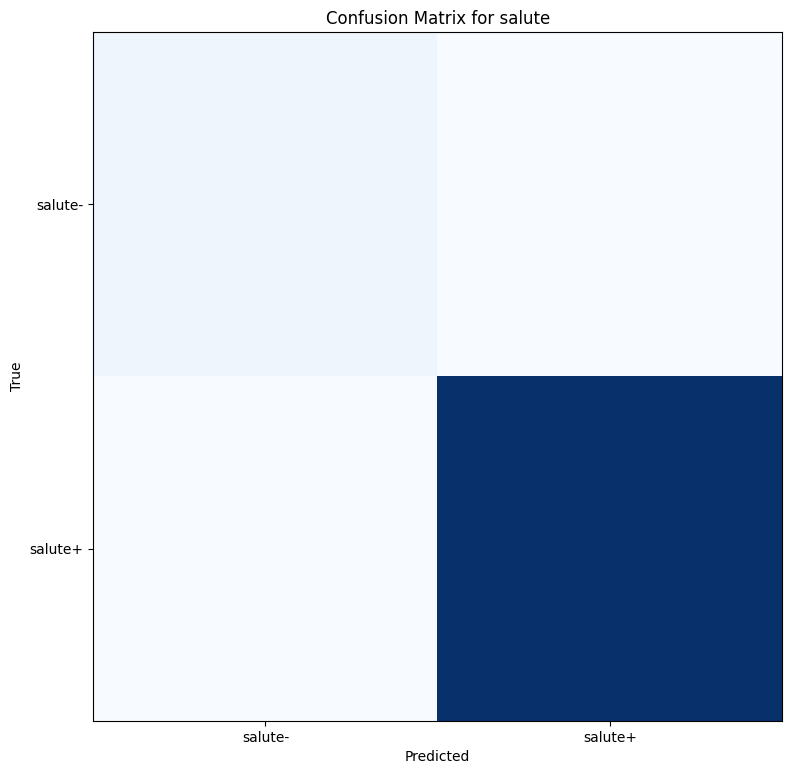

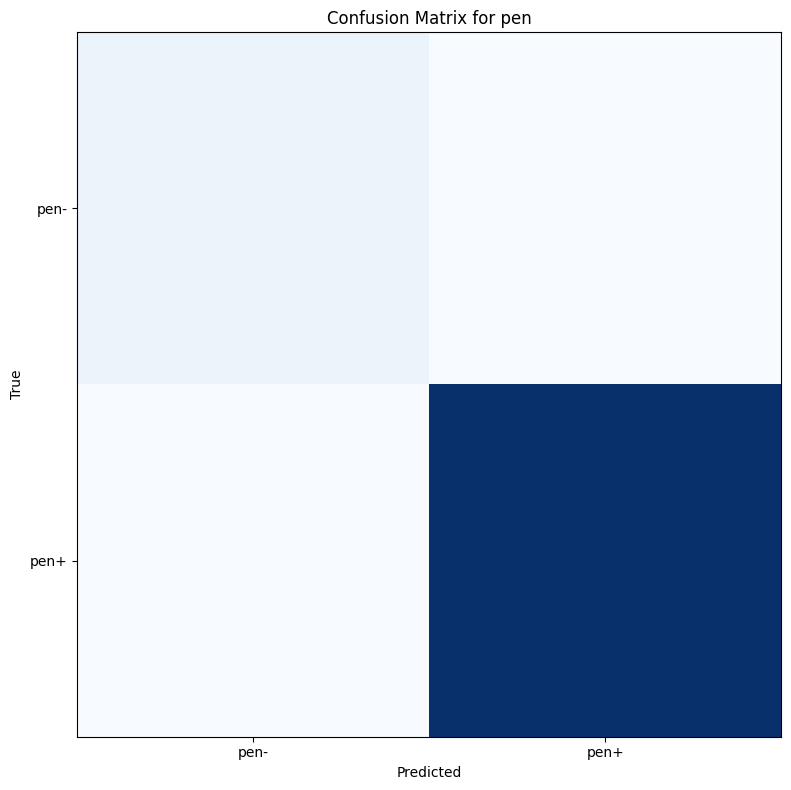

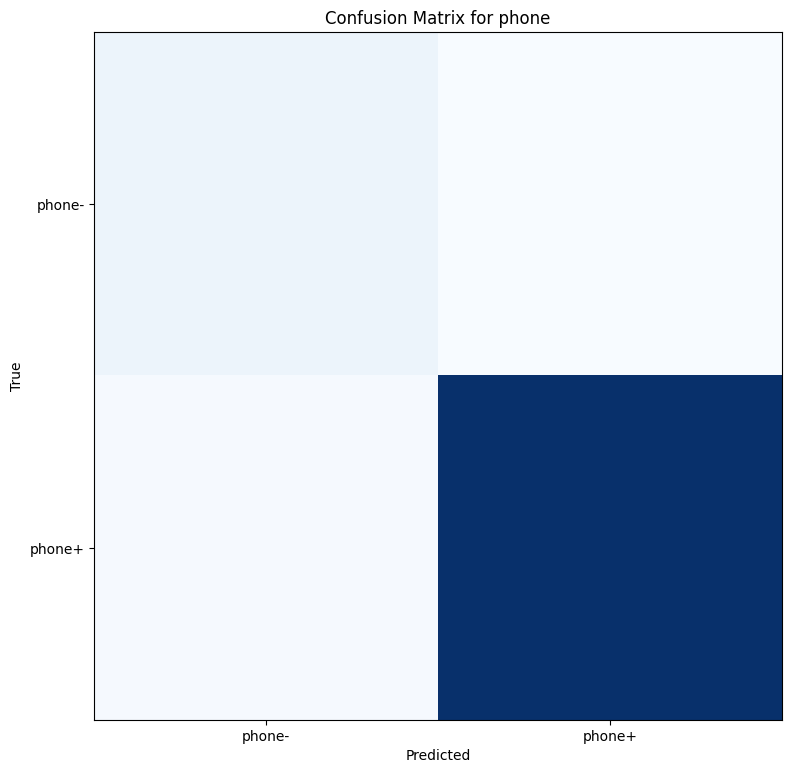

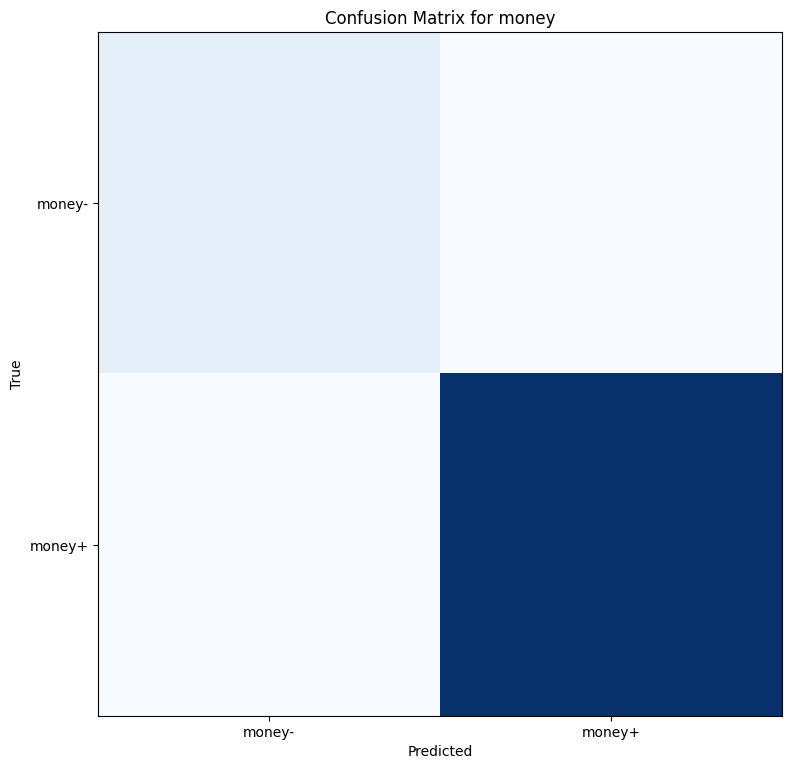

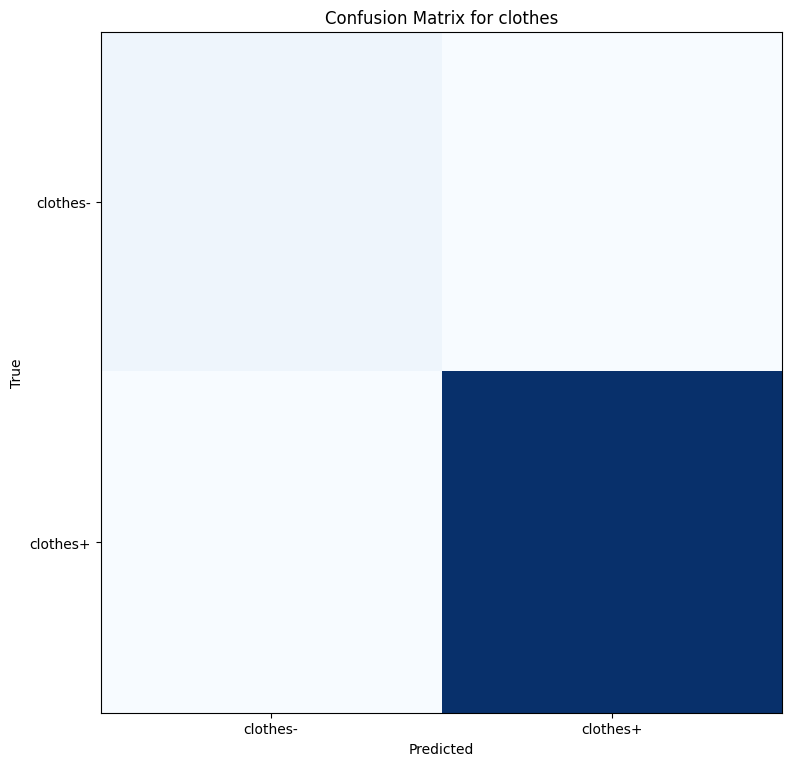

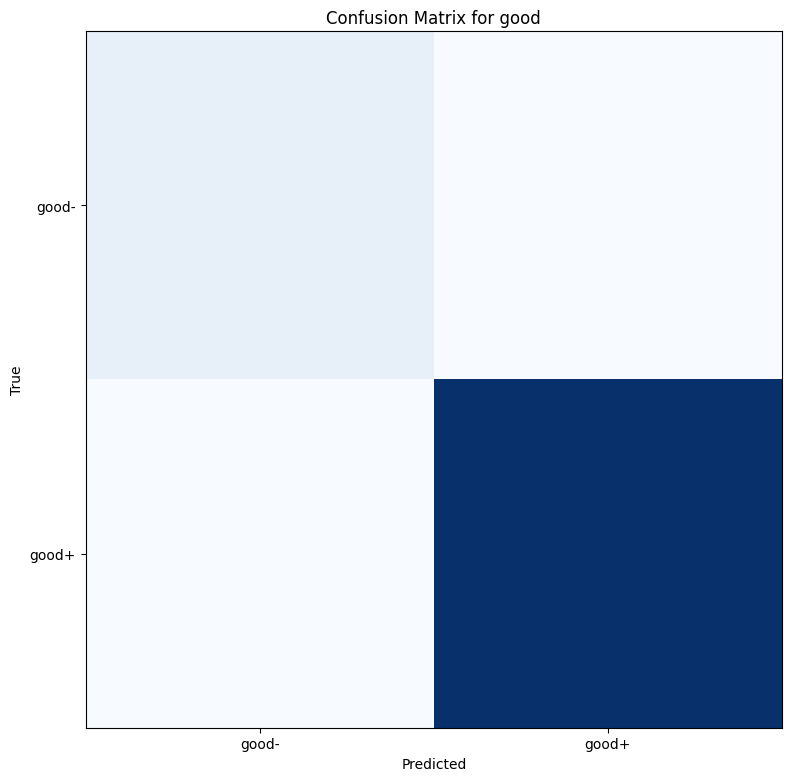

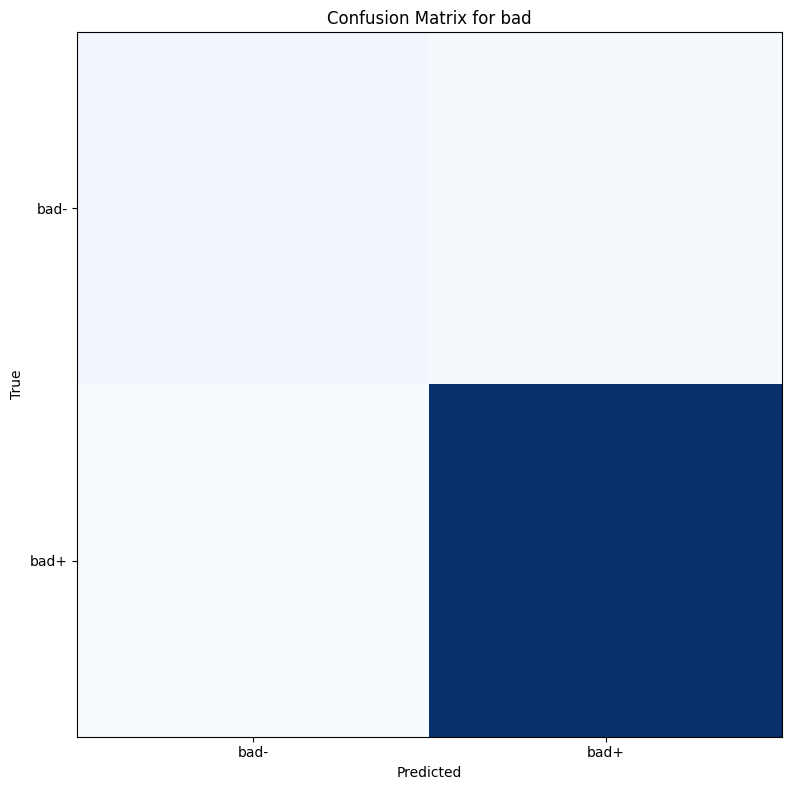

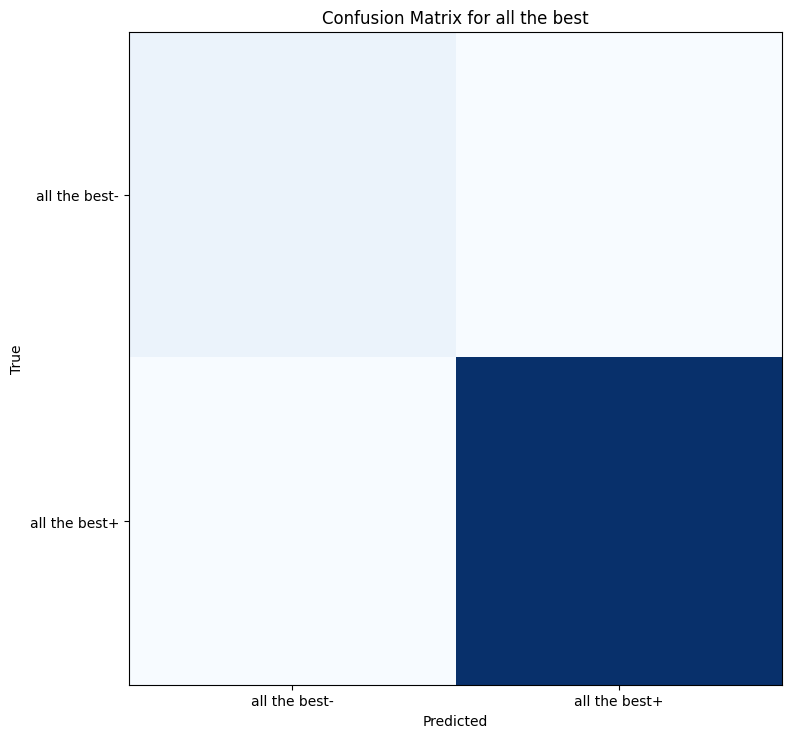

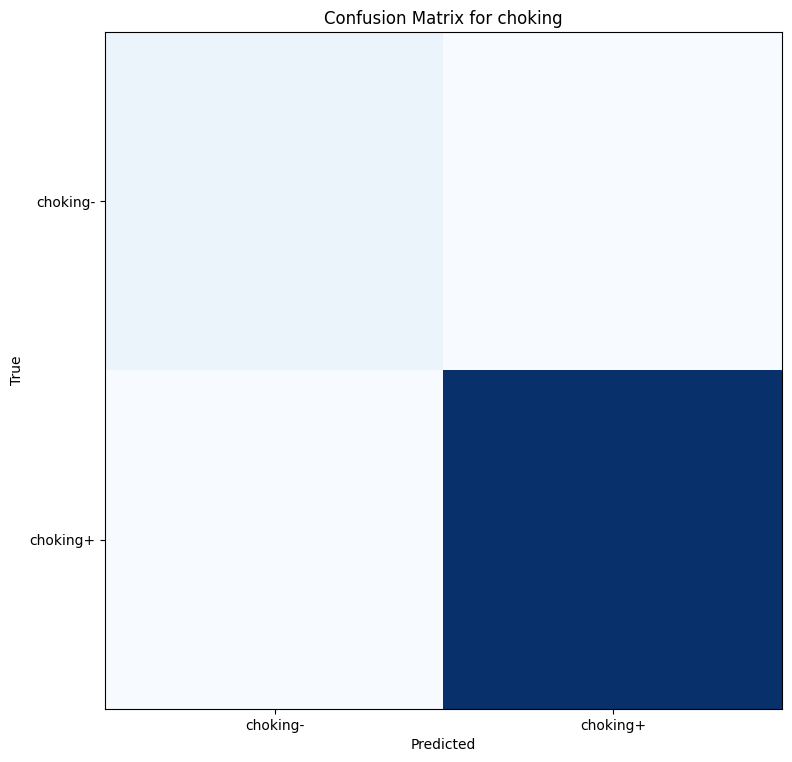

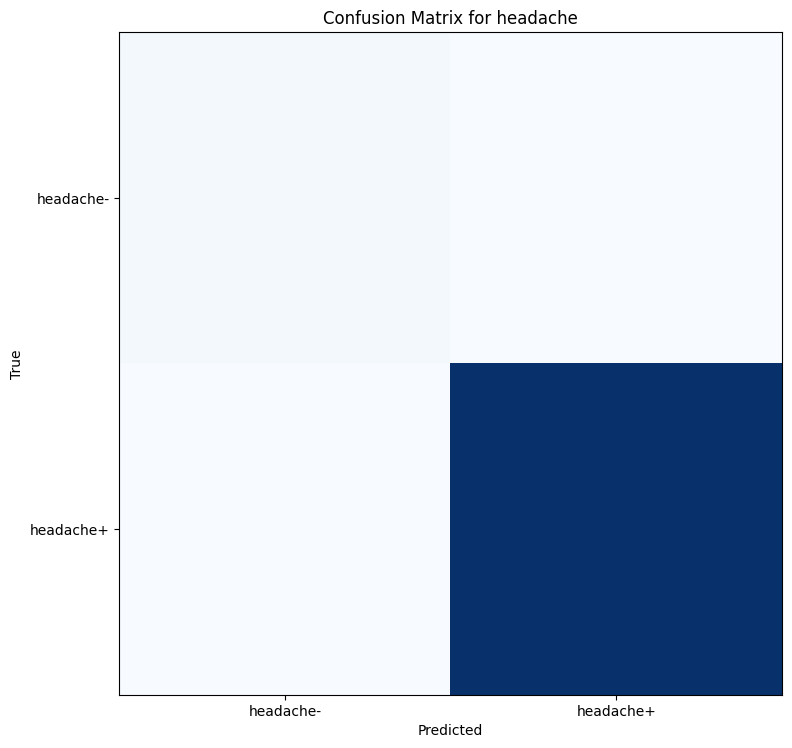

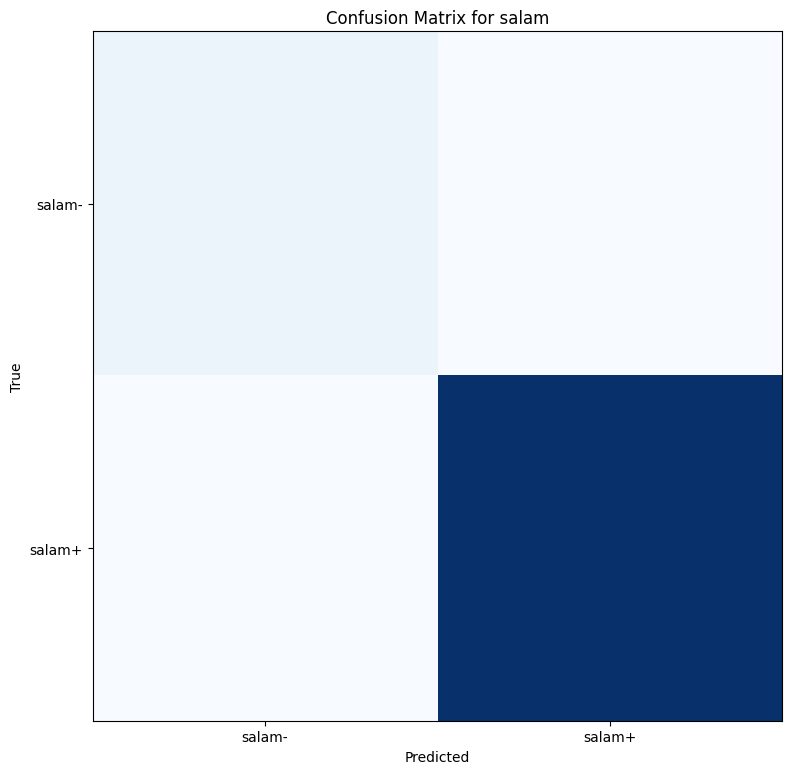

In [134]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
# Define your true labels and predicted labels
y_true = ytrue # your true labels
y_pred = yhat # your predicted labels

# Get the confusion matrices
cm = multilabel_confusion_matrix(y_true, y_pred)

# Print the classification report with metrics
print(classification_report(y_true, y_pred))

# Plot the confusion matrices with colors
classes = ['hello','namaste','i love you', 'thanks', 'noaction', 'what', 'where', 'scissors', 'what time', 'salute', 'pen', 'phone', 'money', 'clothes', 'good', 'bad', 'all the best','choking', 'headache', 'salam'] # your class labels

for i, cls in enumerate(classes):
    fig, axs = plt.subplots(figsize=(8,8))
    cm_i = cm[i]
    cm_i_arr = np.array([[cm_i[1][1], cm_i[0][1]], [cm_i[1][0], cm_i[0][0]]])
    axs.imshow(cm_i_arr, cmap='Blues')
    axs.set_xticks([0, 1])
    axs.set_yticks([0, 1])
    axs.set_xticklabels([cls+'-', cls+'+'])
    axs.set_yticklabels([cls+'-', cls+'+'])
    axs.set_xlabel('Predicted')
    axs.set_ylabel('True')
    axs.set_title('Confusion Matrix for '+cls)
    
    plt.tight_layout()
    plt.show()


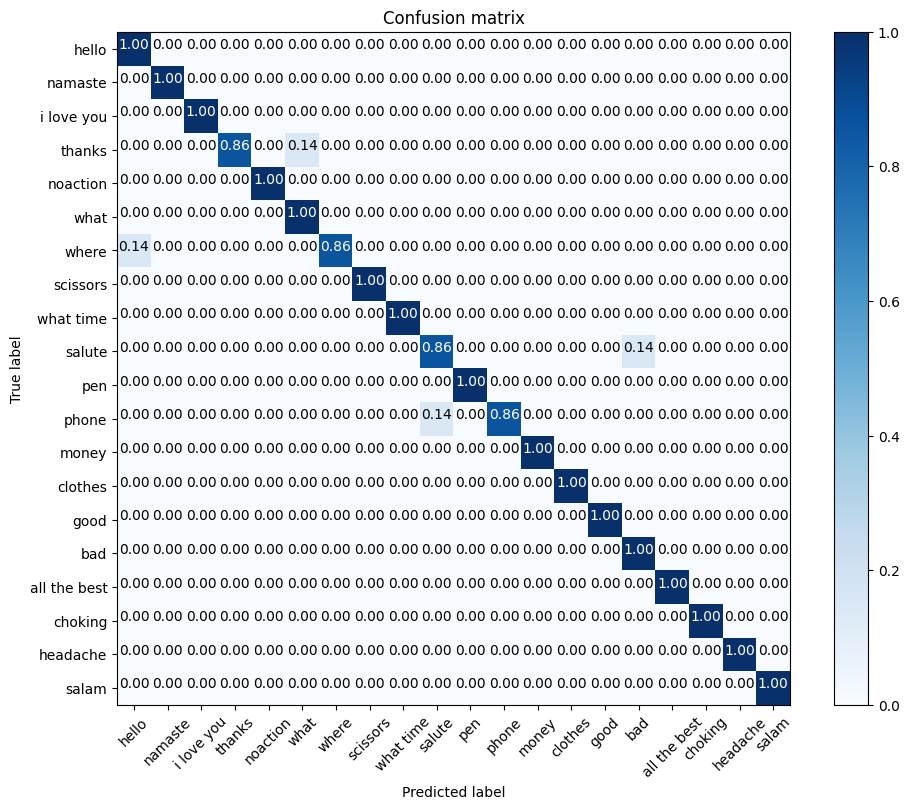

In [142]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# assuming ytrue and yhat are lists of predictions and true labels
ytrue = np.array(ytrue)
yhat = np.array(yhat)

# Compute confusion matrix
cm = confusion_matrix(ytrue.argmax(axis=1), yhat.argmax(axis=1))
# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f'  # Format for displaying values in heatmap
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


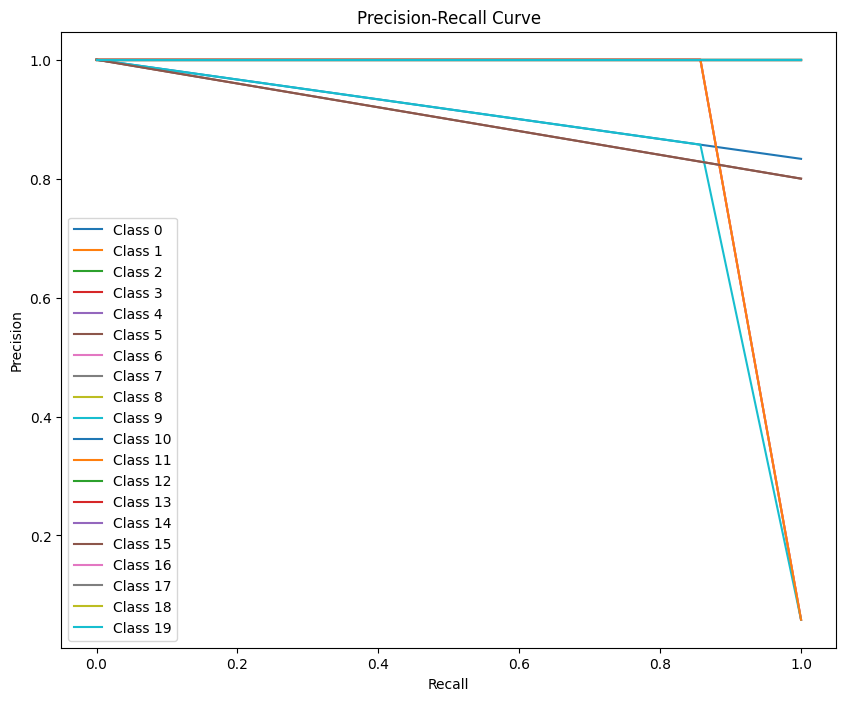

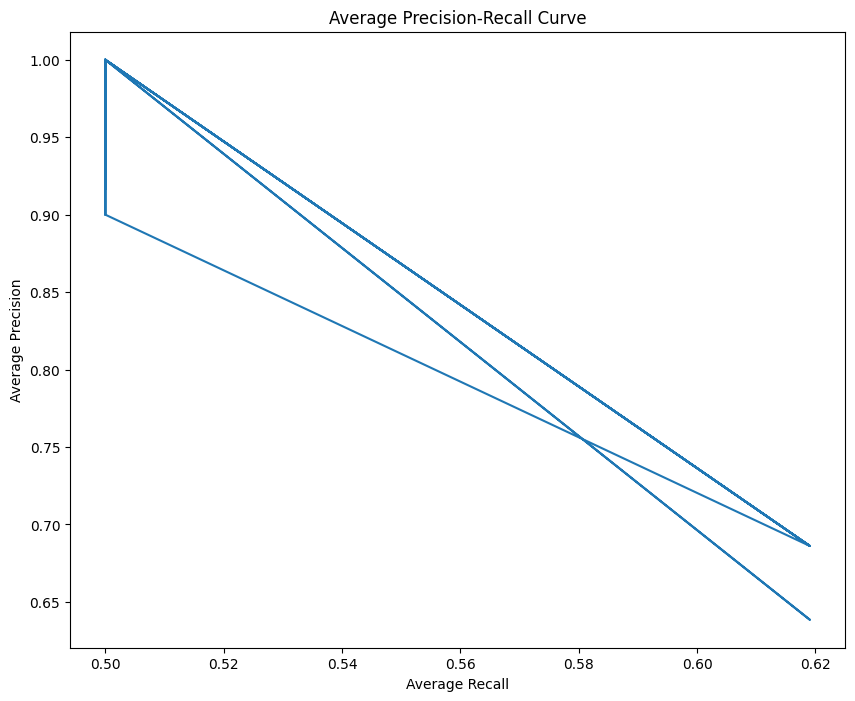

In [133]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# y_true is the true labels, and yhat is the predicted labels
# convert the labels to binary format using one-hot encoding
y_true_binarized = label_binarize(ytrue, classes=list(range(20)))
yhat_binarized = label_binarize(yhat, classes=list(range(20)))

# compute the precision and recall for each class separately
precision = dict()
recall = dict()
for i in range(20):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], yhat_binarized[:, i])

# compute the average precision and recall across all classes
avg_precision = dict()
avg_recall = dict()
for i in range(20):
    avg_precision[i] = np.average(precision[i])
    avg_recall[i] = np.average(recall[i])

# plot the precision-recall curve for each class separately
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
for i in range(20):
    plt.plot(recall[i], precision[i], label=f"Class {i}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# plot the average precision-recall curve across all classes
plt.figure(figsize=(10,8))
plt.plot(list(avg_recall.values()), list(avg_precision.values()))
plt.xlabel("Average Recall")
plt.ylabel("Average Precision")
plt.title("Average Precision-Recall Curve")
plt.show()


In [109]:
accuracy_score(ytrue, yhat)

0.9666666666666667

In [144]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming ytrue and yhat are arrays of true and predicted values, respectively, with shape (num_samples, num_classes)
ytrue = np.array(ytrue)
yhat = np.array(yhat)

# Calculate MAE, RMSE, MAPE, and R-squared values for each class
mae_scores = mean_absolute_error(ytrue, yhat, multioutput='raw_values')
rmse_scores = np.sqrt(mean_squared_error(ytrue, yhat, multioutput='raw_values'))
mape_scores = np.mean(np.abs((ytrue - yhat) / ytrue), axis=0) * 100
r2_scores = r2_score(ytrue, yhat, multioutput='raw_values')

# Print the metrics for each class
for i in range(num_classes):
    print('Class {}:'.format(i))
    print('MAE: {:.4f}'.format(mae_scores[i]))
    print('RMSE: {:.4f}'.format(rmse_scores[i]))
    print('MAPE: {:.4f}%'.format(mape_scores[i]))
    print('R-squared: {:.4f}'.format(r2_scores[i]))
    print()
    
# Calculate the overall metrics for all classes
overall_mae = mean_absolute_error(ytrue, yhat)
overall_rmse = np.sqrt(mean_squared_error(ytrue, yhat))
overall_mape = np.mean(np.abs((ytrue - yhat) / ytrue)) * 100
overall_r2 = r2_score(ytrue, yhat)

# Print the overall metrics
print('Overall metrics:')
print('MAE: {:.4f}'.format(overall_mae))
print('RMSE: {:.4f}'.format(overall_rmse))
print('MAPE: {:.4f}%'.format(overall_mape))
print('R-squared: {:.4f}'.format(overall_r2))
print('Accuracy: ',accuracy_score(ytrue, yhat))

Class 0:
MAE: 0.0083
RMSE: 0.0913
MAPE: nan%
R-squared: 0.7913

Class 1:
MAE: 0.0000
RMSE: 0.0000
MAPE: nan%
R-squared: 1.0000

Class 2:
MAE: 0.0000
RMSE: 0.0000
MAPE: nan%
R-squared: 1.0000

Class 3:
MAE: 0.0083
RMSE: 0.0913
MAPE: nan%
R-squared: 0.8483

Class 4:
MAE: 0.0000
RMSE: 0.0000
MAPE: nan%
R-squared: 1.0000

Class 5:
MAE: 0.0083
RMSE: 0.0913
MAPE: nan%
R-squared: 0.7414

Class 6:
MAE: 0.0083
RMSE: 0.0913
MAPE: nan%
R-squared: 0.8483

Class 7:
MAE: 0.0000
RMSE: 0.0000
MAPE: nan%
R-squared: 1.0000

Class 8:
MAE: 0.0000
RMSE: 0.0000
MAPE: nan%
R-squared: 1.0000

Class 9:
MAE: 0.0167
RMSE: 0.1291
MAPE: nan%
R-squared: 0.6966

Class 10:
MAE: 0.0000
RMSE: 0.0000
MAPE: nan%
R-squared: 1.0000

Class 11:
MAE: 0.0083
RMSE: 0.0913
MAPE: nan%
R-squared: 0.8483

Class 12:
MAE: 0.0000
RMSE: 0.0000
MAPE: nan%
R-squared: 1.0000

Class 13:
MAE: 0.0000
RMSE: 0.0000
MAPE: nan%
R-squared: 1.0000

Class 14:
MAE: 0.0000
RMSE: 0.0000
MAPE: nan%
R-squared: 1.0000

Class 15:
MAE: 0.0083
RMSE: 0.0913


C:\Users\SAIYAM ARORA\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\SAIYAM ARORA\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\SAIYAM ARORA\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\SAIYAM ARORA\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


0.9666666666666667

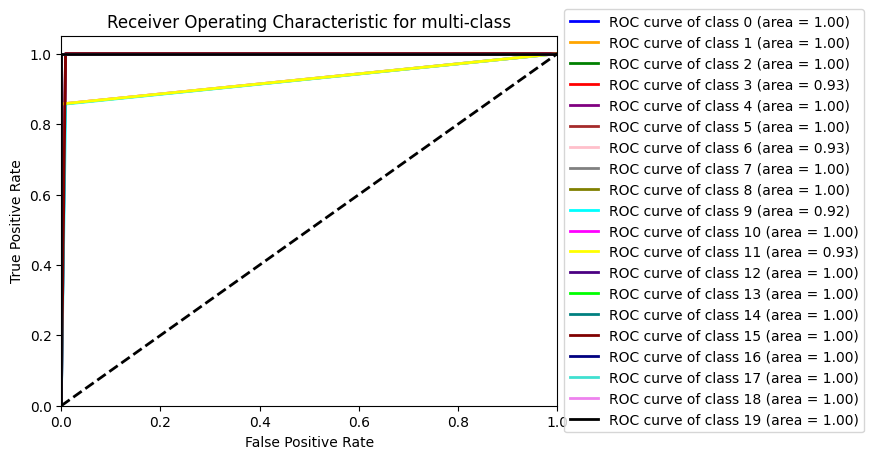

In [141]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# assuming ytrue and yhat have shape (n_samples, 20)
from sklearn.preprocessing import label_binarize

ytrue = label_binarize(ytrue, classes=list(range(20)))
yhat = label_binarize(yhat, classes=list(range(20)))

n_classes = 20
fpr = [None] * n_classes
tpr = [None] * n_classes
roc_auc = [None] * n_classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
          'magenta', 'yellow', 'indigo', 'lime', 'teal', 'maroon', 'navy', 'turquoise', 'violet', 'black']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # adjust legend position
plt.show()

In [110]:
from scipy import stats

In [111]:
import numpy as np
import cv2

colors = [(245,117,16), (117,245,16), (16,117,245)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        color = tuple(np.array(colors[num], dtype=np.uint8))
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), color, -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return output_frame

#plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))


In [112]:
import pyttsx3
import threading
sequence = []
sentence = []
predictions = []
threshold = 0.7
engine = pyttsx3.init()
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.insert(0,keypoints)
        sequence = sequence[:30]
        
        print('len ', len(sequence))
        res = None
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            predicted_sign = actions[np.argmax(res)]  # get the predicted sign
            print(predicted_sign)

            # Convert predicted sign to speech
            def speak():
                engine.say(predicted_sign)
                engine.runAndWait()  # play the speech
            thread = threading.Thread(target=speak)
            thread.start()

        #3 Viz logic
        #if res[np.argmax(res)].all() > threshold:
        if res is not None and res[np.argmax(res)].all() > threshold:

            if len(sentence) > 0:
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])
        if len(sentence) > 5: 
            sentence = sentence[-5:]
        
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  3
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  4
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  5
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  6
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  7
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  8
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  9
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  10
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  11
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  12
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  13
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  14
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  15
<class 'mediapipe.python.solution_

Exception in thread Thread-945:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-946:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-948:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-949:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-951:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-952:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-954:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-955:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-957:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-958:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-960:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-961:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-963:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-965:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-966:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-968:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-969:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-970:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-971:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-972:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-973:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-974:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-975:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-976:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-978:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-979:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-980:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-981:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-983:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-984:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-985:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-986:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-987:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-989:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-990:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-992:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-993:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-994:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-995:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-996:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-997:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1000:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1001:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1002:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1003:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1004:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1005:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1006:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1007:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1008:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1009:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1011:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1012:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1013:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1014:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1015:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1016:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1017:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1018:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1019:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1020:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1022:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1023:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1024:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1025:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1026:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1027:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1028:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1029:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1031:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1032:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1034:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1035:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1036:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1037:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1038:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1039:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1040:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1041:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1042:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1043:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1044:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1046:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1047:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1048:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1049:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1051:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1052:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-1053:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1054:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1055:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1056:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1058:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1059:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1060:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1061:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1062:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1063:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1064:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1065:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1066:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1067:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1068:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1070:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1071:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1073:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1074:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1075:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1076:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1077:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1078:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1079:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1080:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1082:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1083:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1084:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1085:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1086:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1087:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1089:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1090:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1091:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1092:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1094:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1095:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1096:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1097:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1098:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1099:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1100:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1101:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1102:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1103:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1106:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1107:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1108:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1109:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1110:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1111:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1112:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1113:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1115:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1116:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1118:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1119:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1121:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1122:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1123:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1124:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1125:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1126:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1127:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1128:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1129:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1131:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1132:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1134:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1135:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1136:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1137:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1138:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1139:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1140:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1141:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1142:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1144:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1145:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1146:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1147:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1148:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1149:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1150:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1151:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1152:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1153:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1154:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1155:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1157:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1158:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1159:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1160:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1161:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1162:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1163:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1164:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1165:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1166:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1169:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1170:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1171:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1172:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1173:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1174:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1175:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1176:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1177:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1178:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1179:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1181:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1182:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1183:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1184:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1185:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1187:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1188:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1189:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1190:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1192:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1193:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1195:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1196:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1198:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1199:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1201:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1202:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1204:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1206:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1207:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1208:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1210:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1211:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1212:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1213:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1214:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1215:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-1217:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1219:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1220:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1221:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1222:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1224:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1225:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-1226:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1227:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-1228:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1229:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-1231:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1232:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-1233:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1234:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1235:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1236:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1237:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1238:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1239:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1240:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1242:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1243:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1244:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1245:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1247:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1248:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1250:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1251:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1253:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1255:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1256:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1257:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1258:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1259:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1260:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1261:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1262:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1263:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1264:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1266:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1268:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1269:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1270:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1271:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1272:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1273:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-1275:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1276:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1277:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1278:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1279:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-1281:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1282:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1284:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1285:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1286:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1287:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1288:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1289:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-1290:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1291:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-1293:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1294:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1296:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1297:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1298:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1299:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1300:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1301:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1303:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1305:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1306:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1307:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1308:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1310:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1311:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1312:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1313:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1314:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1315:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1316:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1317:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1318:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1319:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1321:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1322:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1323:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1324:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1325:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1326:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1327:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1328:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1330:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1331:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1333:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1334:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1335:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1336:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1337:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1338:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1340:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1341:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1342:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1343:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1345:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1346:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1348:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1349:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1351:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1352:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1354:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1355:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1356:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1357:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-1359:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1360:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1361:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1362:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1363:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1364:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1365:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1366:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1367:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1368:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1369:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1371:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1372:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1373:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1374:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1375:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1376:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1378:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1379:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1380:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1381:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1382:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1383:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1385:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1386:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1388:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1389:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1390:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1391:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1392:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1393:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1394:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1395:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1396:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1398:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1399:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1401:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1402:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1404:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1405:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1406:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1407:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1409:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1410:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1412:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1413:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1415:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1416:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1418:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1419:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1420:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1421:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1423:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1425:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1426:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1427:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1428:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1430:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1431:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1432:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1433:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1435:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1436:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1438:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1439:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1441:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1442:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1444:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1445:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1447:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1448:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1449:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1450:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1452:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1453:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1454:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1455:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1456:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1457:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1461:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1462:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1463:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1465:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1467:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1468:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1469:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1470:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1471:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1472:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1473:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1474:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1475:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1476:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1478:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1479:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1481:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1482:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1483:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1484:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1485:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1486:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1487:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1488:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1491:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1492:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1493:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1494:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1496:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1497:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1499:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1500:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1501:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1502:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1505:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1506:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1507:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1508:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1509:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1510:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1512:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1513:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1515:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1516:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1518:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1519:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1520:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1521:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1522:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1523:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1524:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1525:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1526:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1527:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1528:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1530:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1531:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1532:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1533:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1534:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1535:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1537:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1538:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1539:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1540:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1542:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1543:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1545:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1546:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1547:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1548:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1549:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1550:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1552:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1553:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1555:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1556:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1558:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1559:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1561:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1562:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1564:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1565:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1566:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-1568:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1569:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1570:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1571:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1573:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1574:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1576:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1577:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1579:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1580:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1582:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1583:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1584:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1585:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1587:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1588:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1590:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1591:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1593:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1595:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1596:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1597:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1598:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1599:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1600:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1602:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1603:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1606:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1607:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1608:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1609:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1611:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1612:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1613:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1614:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1615:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1616:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1617:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1619:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1620:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1621:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1622:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1624:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1625:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1626:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1627:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1629:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1630:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1632:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1633:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1634:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1635:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1636:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1637:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1639:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1640:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1641:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1642:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1645:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1646:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1647:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1648:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1649:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1650:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1652:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1653:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1654:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1655:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1656:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1658:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1659:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1660:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1661:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1662:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1663:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1664:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1665:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1667:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1669:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1670:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1671:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1672:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1673:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1675:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1676:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1677:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1678:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-1680:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1681:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1682:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1683:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1684:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1685:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1686:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1687:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-1689:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-1691:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1692:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1694:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1695:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-1696:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1697:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1699:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1700:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1701:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1702:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-1704:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1705:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1707:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1708:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1709:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1710:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1712:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1713:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1714:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1715:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1718:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1719:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1720:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1721:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1722:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1723:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1724:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1725:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1727:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1728:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1729:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1731:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1732:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1734:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1735:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1736:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1737:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1739:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1740:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1741:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1742:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1744:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1745:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1747:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1748:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1749:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1750:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1751:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1752:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1753:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1754:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-1756:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1757:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1758:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1759:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1760:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1761:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1763:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1764:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1765:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1766:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1768:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1769:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1770:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1771:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1772:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1773:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1774:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1775:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1776:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1777:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1778:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1779:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1781:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1782:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1783:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1784:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1785:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1786:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1788:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1789:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1790:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1791:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1794:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1795:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1797:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1798:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-1799:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1800:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1801:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1802:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1803:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1804:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1805:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1807:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1808:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1809:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1810:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1812:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1813:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1814:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1815:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1816:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1817:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1819:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1820:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1821:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1822:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1823:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1824:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1825:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1826:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1828:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1829:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1830:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1832:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1833:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1835:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1836:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1837:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1838:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1839:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1840:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1841:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1842:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1843:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1845:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1846:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1848:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1849:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-1851:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1852:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1853:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1854:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1855:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1857:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1858:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1859:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1860:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1861:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1862:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1863:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1864:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1866:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1867:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1868:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1870:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1871:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1872:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1873:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1875:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1876:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1877:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1878:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1880:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1881:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1883:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1884:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
clothes


Exception in thread Thread-1885:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1886:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1887:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1888:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1889:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1890:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1891:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1892:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1893:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1895:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1896:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1897:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1898:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1899:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1900:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1901:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1902:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1903:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1904:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1905:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1906:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1908:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1909:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1910:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1911:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1912:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1913:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-1914:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1915:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1916:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1917:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1919:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1921:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1922:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1923:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1924:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1925:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1926:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1927:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1928:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1930:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1931:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1932:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1934:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1935:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1936:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1937:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-1938:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1939:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1941:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1942:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1944:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1945:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1947:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1948:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1949:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1950:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1952:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1953:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1954:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1955:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1957:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1959:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1960:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1962:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1963:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1964:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1965:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1966:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1967:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1970:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1971:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1972:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1973:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1974:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1975:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1976:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1977:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-1978:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1979:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1981:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1982:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1983:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1984:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-1985:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1986:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1987:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1988:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1989:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1990:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1991:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1993:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1994:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1995:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1996:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1997:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-1998:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-1999:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2000:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-2001:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2002:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-2004:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2005:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2006:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2007:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-2008:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2009:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-2012:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2013:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2015:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2016:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2017:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2018:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2019:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2020:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2021:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2022:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2023:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2024:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2026:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2027:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2028:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2029:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2030:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2031:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2032:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2033:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2034:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2035:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2036:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2037:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2039:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2040:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2041:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2042:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2044:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2045:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2046:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2047:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2048:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2049:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2051:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2053:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2054:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2056:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2057:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2059:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2060:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time


Exception in thread Thread-2061:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2062:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2063:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2064:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what time
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2066:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2067:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2068:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2069:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2071:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2072:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-2073:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2074:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-2076:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2077:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
pen


Exception in thread Thread-2079:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2080:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2082:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2083:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2084:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2085:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2086:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2087:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2089:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2091:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2092:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2093:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2094:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2095:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2096:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2098:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2099:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2100:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2102:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2103:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2104:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2105:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2106:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2107:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2109:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2110:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2111:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2113:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2114:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2115:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2116:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2117:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2118:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2119:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2120:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2122:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2124:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2125:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2126:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2128:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2129:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2130:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2131:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2133:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2134:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2135:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2137:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2138:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2139:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2141:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2142:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2143:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2144:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2146:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2147:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2150:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2151:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2152:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2153:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2155:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2156:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2157:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2158:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2159:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2160:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2161:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2163:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2164:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2165:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2166:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2168:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2169:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2170:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2171:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2172:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2174:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2175:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2176:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2177:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2178:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2179:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2181:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2182:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2183:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2185:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2186:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2187:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2188:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2189:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2190:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2191:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2192:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2194:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2195:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2198:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2199:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2200:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2201:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2203:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2204:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2205:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2206:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2207:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2208:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2210:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2212:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2213:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-2214:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2215:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-2217:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2218:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-2219:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2220:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2221:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2222:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2224:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2225:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-2227:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2228:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-2229:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2230:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-2231:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2232:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2234:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-2236:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2237:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-2239:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2240:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-2241:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2242:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-2244:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2245:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2247:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2248:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2250:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2251:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2252:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2253:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-2254:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2255:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-2256:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2257:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-2258:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2259:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2260:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2261:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2264:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2265:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2267:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2268:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2269:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2270:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2271:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2272:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2273:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2274:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2276:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2277:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2278:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2279:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2280:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2281:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2283:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2284:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-2285:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2286:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2288:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2289:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2290:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2291:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2292:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2293:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2294:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2295:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2297:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2298:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2300:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2301:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2302:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2303:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2304:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2305:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2306:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2307:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2308:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2309:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-2311:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2312:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-2314:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2315:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2317:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2318:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2319:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2320:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-2323:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2324:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-2326:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2327:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2329:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2330:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2332:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2333:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2334:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2336:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2337:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2338:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2339:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2340:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2341:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2342:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2343:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2345:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2346:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2348:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2349:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2350:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2351:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2352:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2353:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2354:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2355:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2356:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2357:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2359:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2361:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2362:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2363:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2364:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2365:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2366:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2367:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2368:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2370:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2371:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2373:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2374:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2375:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2376:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2378:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2379:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2381:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2382:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2383:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2385:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2386:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2388:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2389:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2390:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2391:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2393:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2394:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2397:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2398:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2399:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2400:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2401:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2402:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2404:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2405:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2407:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2409:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2410:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2412:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2413:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2414:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2415:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2416:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2417:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2419:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2421:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2422:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2423:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2424:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2425:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2426:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2427:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2428:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2429:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2430:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2433:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2434:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2435:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2436:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2437:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2438:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2439:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2440:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2441:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2442:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2443:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2445:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2446:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2447:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2448:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2449:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2450:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2451:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2452:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2453:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2454:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2455:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2457:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2458:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2459:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2460:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2461:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2462:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2463:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2464:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2466:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2467:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2469:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2470:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2471:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2472:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2474:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2475:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2476:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2477:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2478:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2479:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2481:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2482:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2483:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2484:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-2485:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2486:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2488:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2489:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2490:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2491:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2493:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2494:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2495:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2496:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2497:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2498:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2499:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2500:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2502:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2503:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2505:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2506:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2508:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2509:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2510:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2511:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2513:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2514:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2515:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2516:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2518:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2519:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2520:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2521:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2522:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2523:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2524:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2525:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-2528:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2530:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2531:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2532:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2533:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2534:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-2535:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2536:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2537:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2538:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2539:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2540:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2542:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2543:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2544:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2545:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2547:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2548:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2549:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2550:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2552:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2553:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2555:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2556:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2557:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2558:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2559:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2560:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2562:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2563:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2564:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2565:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2567:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2568:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2569:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2570:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2571:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2572:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2573:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2574:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
bad


Exception in thread Thread-2575:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2576:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2579:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2580:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2581:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2582:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2583:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2584:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2585:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2586:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2587:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2588:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2590:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2591:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2592:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2593:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2594:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2595:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2597:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2598:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2599:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2600:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2602:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2603:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2605:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2606:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute


Exception in thread Thread-2607:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2608:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2609:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2610:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2611:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2612:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2614:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2615:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2616:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2617:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2618:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2619:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salute
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2620:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2621:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2622:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2623:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2625:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2626:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2628:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2629:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2630:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2631:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2632:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2633:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2634:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2635:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2637:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2638:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2639:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2640:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2641:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2642:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2643:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2644:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2645:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2646:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2647:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2649:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2650:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2651:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2652:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2653:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2654:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2655:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2656:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2658:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2659:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2661:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2662:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2663:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2664:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2665:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2666:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2668:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2669:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2671:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2672:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2674:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2675:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2676:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2677:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2679:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2680:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2682:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2683:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2684:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2685:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2687:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2688:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2690:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2691:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2692:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2693:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2694:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2695:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2697:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2699:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2700:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2701:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2702:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2703:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2704:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2705:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2706:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2707:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2708:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2709:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2712:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2713:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2715:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2716:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2717:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2718:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2719:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2720:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2722:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2723:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2725:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2726:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2727:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2728:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2730:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2731:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2733:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2734:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2738:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2739:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2740:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2741:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2743:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2744:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2745:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2746:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2749:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2750:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2751:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2752:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-2754:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2755:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2757:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2758:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2759:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2760:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2762:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2763:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2764:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2765:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2766:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2767:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2769:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2770:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2771:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2773:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2774:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2775:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2776:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2777:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2778:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2779:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2780:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2781:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2782:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2784:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2785:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2786:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2787:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-2789:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2790:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2792:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2793:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2794:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2796:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2797:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2798:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2799:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2800:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2801:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2802:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2803:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-2804:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2805:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2807:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2808:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2810:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2811:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2812:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2813:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2814:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2815:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2816:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2818:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2819:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2820:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2821:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2822:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2823:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2825:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2826:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2827:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2828:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2830:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2831:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2832:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2833:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2834:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2835:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2836:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2837:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-2838:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2839:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2842:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2843:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2844:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2845:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2846:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2847:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2849:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2850:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2852:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2853:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2855:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2856:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2857:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2858:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2859:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2860:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2861:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2863:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2864:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2866:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2867:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2869:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2870:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2871:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2872:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-2874:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2875:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2876:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2878:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2879:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2880:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2881:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-2883:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2884:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-2885:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2886:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2887:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2888:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2890:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2891:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2892:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2893:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2894:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2895:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2896:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2897:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2898:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2899:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2900:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2902:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2903:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2904:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2905:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2906:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2907:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2908:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where


Exception in thread Thread-2909:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2910:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
where
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-2913:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2914:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2916:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2917:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2918:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2919:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2920:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2921:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-2922:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2923:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-2925:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2926:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-2928:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2929:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-2931:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2932:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2934:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-2936:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2937:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2939:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2940:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2941:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2942:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2944:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2945:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-2946:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2947:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2949:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2950:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-2951:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2952:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2954:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2955:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-2956:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2957:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2959:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2960:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2962:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2963:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2965:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2966:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2967:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2968:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2969:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2970:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2972:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2973:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2975:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2976:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2977:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2978:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2979:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2980:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2981:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2982:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2983:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2984:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2985:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2987:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2988:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2989:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2990:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2991:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2992:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-2993:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2994:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2995:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-2996:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-2998:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3000:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3001:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3003:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3004:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3005:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3006:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3007:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3008:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3009:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3010:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3013:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3014:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3015:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3016:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3017:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3018:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3019:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3020:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3021:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3022:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3023:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3024:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3026:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3027:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3028:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3029:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3030:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3031:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3032:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3033:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3035:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3036:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3039:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3040:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3041:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3042:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3043:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3044:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3046:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3047:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3048:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3049:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3051:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3052:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3053:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3054:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3055:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3056:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3057:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3058:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3059:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3060:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3062:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3063:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3064:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3065:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3067:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3068:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3069:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3070:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3071:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3072:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3074:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3075:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3076:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3077:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3079:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3080:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3081:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3082:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3084:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3086:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3087:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3088:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3089:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3090:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3091:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3093:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3094:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3096:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3097:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3099:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3100:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3102:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3103:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3105:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3106:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3108:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3109:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3112:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3113:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3115:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3116:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3117:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3118:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3120:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3121:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3123:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3125:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3126:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3127:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3129:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3130:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3131:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3132:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3133:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3134:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3136:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3137:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3139:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3140:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3142:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3143:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3145:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3146:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3148:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3149:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3151:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3152:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3153:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3155:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3156:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3157:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3159:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3160:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3162:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3163:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3165:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3166:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3167:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3168:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3170:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3171:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3172:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3173:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3177:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3178:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3180:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3181:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3182:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3184:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3185:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3186:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3188:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3189:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-3191:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3192:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3194:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3195:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3197:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3198:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3200:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3201:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3202:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3203:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-3205:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3206:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3209:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3210:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3212:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3213:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3215:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3216:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3218:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3219:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3222:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3223:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3225:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3226:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3228:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3229:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3230:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3231:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3232:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3234:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3235:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3236:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3237:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3239:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3240:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3242:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3243:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3245:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3246:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3247:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3248:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3249:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3250:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3251:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3252:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3253:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3254:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3256:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3257:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3258:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3259:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3260:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3261:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3263:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3264:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3265:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3266:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3268:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3270:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3271:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3273:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3274:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3275:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3276:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3278:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3279:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3280:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3281:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3283:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3284:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3286:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3287:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3288:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3289:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3290:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3291:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3292:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3294:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3295:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3296:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3297:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3298:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3299:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3300:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3301:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3302:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3303:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3304:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3305:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3307:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3308:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3310:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3311:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3312:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3313:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3315:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3316:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3317:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3318:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3319:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3321:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3322:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3324:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3325:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3326:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3327:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3328:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3329:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3330:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3331:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3332:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3334:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3335:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3336:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3337:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3338:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3339:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3340:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3341:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3342:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3343:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3344:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3346:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3347:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3349:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3350:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3352:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3353:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3354:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3355:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3357:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3359:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3360:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3361:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3362:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3365:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3366:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3367:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3368:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3370:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3372:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3373:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3374:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3375:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3377:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3378:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3380:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3381:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3382:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3383:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3385:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3386:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3387:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3388:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3389:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3390:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3391:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3392:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3394:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3395:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3396:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3398:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3399:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3401:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3402:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3403:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3404:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3405:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3406:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3408:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3409:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3412:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3413:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3414:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3415:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3416:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3417:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3419:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3420:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3421:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3422:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3423:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3425:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3426:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3427:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3428:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3429:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3430:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3431:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3432:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3433:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3434:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-3436:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3438:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3439:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3440:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3441:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3443:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3444:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3445:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3446:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3447:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3448:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3450:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3452:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3453:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3455:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3456:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3457:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3458:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3459:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3461:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3462:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3463:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3464:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3465:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3467:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3468:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3469:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3470:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3471:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3472:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3474:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3475:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3476:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3477:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3478:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3479:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3481:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3482:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3483:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3484:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3485:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3486:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3487:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3489:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3490:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3491:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3492:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3493:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3494:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3496:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3497:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-3498:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



len  30
money


Exception in thread Thread-3499:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3500:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3501:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3503:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3504:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3505:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3506:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3507:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3508:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3510:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3511:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3512:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3513:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3514:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3515:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3516:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3518:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3519:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3520:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3521:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3522:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3524:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3525:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3526:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3527:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3528:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3529:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3530:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3531:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3533:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3534:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3535:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3536:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3537:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3538:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3539:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3540:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3541:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3543:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3544:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3545:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3546:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3547:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3548:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache


Exception in thread Thread-3549:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3550:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-3552:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3553:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-3554:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3555:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-3556:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3557:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-3558:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3559:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-3560:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3562:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3563:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3564:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3565:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3566:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3567:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3568:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3569:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3570:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3572:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3573:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3574:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3575:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3576:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3577:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3578:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3579:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3580:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3582:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3583:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3584:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3585:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3586:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3587:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3588:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3589:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3590:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3591:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-3593:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3594:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3595:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3596:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3597:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3598:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3599:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3600:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3601:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3603:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3604:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3605:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3606:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
what


Exception in thread Thread-3607:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3608:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-3609:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3610:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
thanks


Exception in thread Thread-3612:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3613:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3614:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3615:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3616:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3617:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3618:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3619:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3620:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3622:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3623:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3624:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3625:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3626:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3627:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3628:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3629:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3631:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3632:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
money


Exception in thread Thread-3633:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3634:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3635:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3636:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3637:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3638:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3639:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3641:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3642:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3643:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3644:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3645:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3646:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3647:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3648:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3649:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3651:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3652:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3653:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3654:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3655:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3656:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3657:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3658:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3659:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3660:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3662:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3663:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3664:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3665:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3666:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3667:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3668:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3669:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3670:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3671:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3673:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3674:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3675:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3676:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3677:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3678:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3679:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3680:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3681:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3682:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3684:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3685:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3686:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3687:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3688:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3689:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3690:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3691:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3692:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3693:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3695:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3696:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3697:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3698:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3699:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3700:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3701:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3702:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3703:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3704:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3706:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3707:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3708:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3709:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3710:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3711:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3712:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3713:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3714:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3715:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3717:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3718:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam


Exception in thread Thread-3719:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3720:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
salam
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3721:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3722:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3723:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3724:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3725:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3726:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3728:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3729:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3730:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3731:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3732:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3733:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3734:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3735:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
namaste


Exception in thread Thread-3736:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3737:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3738:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3740:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3741:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3742:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3743:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3744:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3745:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3746:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3747:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3748:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
choking


Exception in thread Thread-3750:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3751:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3752:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3753:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3754:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3755:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3756:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3757:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3758:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3759:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3761:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3762:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3763:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3764:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3765:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3766:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3767:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3768:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3769:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3771:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3772:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3773:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3774:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3775:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3776:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3777:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3778:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3779:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3781:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3782:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3783:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3784:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3785:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3786:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3787:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3788:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3789:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-3791:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3792:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-3793:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3794:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you


Exception in thread Thread-3795:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3796:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3797:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3798:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3799:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3801:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3802:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3803:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3804:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
i love you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3805:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3806:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3807:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3808:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3809:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3810:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3812:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3813:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3814:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3815:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3816:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3817:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3818:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3819:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3820:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
hello


Exception in thread Thread-3822:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3823:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3824:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3825:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3826:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3827:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-3828:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3829:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3830:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3832:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3833:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3834:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3835:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3836:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3837:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3838:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3839:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3840:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3842:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3843:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3844:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3845:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
good


Exception in thread Thread-3846:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3847:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3848:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3849:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3850:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3852:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3853:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3854:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3855:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3856:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3857:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-3858:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3859:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3860:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3861:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3863:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3864:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3865:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3866:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3867:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3868:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3869:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3870:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3871:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3872:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3874:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3875:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3876:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3877:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3878:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3879:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3880:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3881:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3882:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3883:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3884:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3886:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3887:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3888:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3889:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3890:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3891:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3892:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3893:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3894:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3895:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3896:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3898:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3899:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3900:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3901:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3902:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3903:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3904:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3905:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
scissors


Exception in thread Thread-3906:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3907:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3908:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3910:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3911:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3912:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3913:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3914:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3915:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3916:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3917:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3918:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3919:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3921:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3922:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3923:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3924:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3925:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3926:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3927:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3928:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
phone


Exception in thread Thread-3929:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3931:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3932:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3933:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3934:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3935:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3936:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3937:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3938:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3939:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3940:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3941:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3942:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3944:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3945:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3946:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3947:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3948:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3949:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3950:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3951:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3952:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3953:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3954:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3956:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3957:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best


Exception in thread Thread-3958:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3959:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
all the best
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3960:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3961:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3962:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3963:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3964:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3965:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3967:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3969:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3970:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3972:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3973:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3974:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3975:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3977:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3978:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30


Exception in thread Thread-3980:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3981:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3983:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3984:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3986:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3987:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3988:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3989:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>


Exception in thread Thread-3990:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3991:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

len  30
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
len  30
noaction


Exception in thread Thread-3992:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\SAIYAM ARORA\AppData\Local\Temp\ipykernel_392\1267764553.py", line 39, in speak
    engine.runAndWait()  # play the speech
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\site-packages\pyttsx3\engine.py", line 177, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started

Exception in thread Thread-3993:
Traceback (most recent call last):
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\SAIYAM ARORA\anaconda3\envs\wiehack\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Use

In [279]:
cap.release()
cv2.destroyAllWindows()